# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 29.8 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2024

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping


def map_variables_same_timeline(vars_list, time_identifiers_lst):
  """
  Creates a dictionary that maps each variable to its timeline.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      vars_list: list of variable names to be analysed.
      time_identifiers_lst: list of timeline identifiers.

  Returns:
      A dictionary with feature names as keys and their timeline as values.
  """
  # dictionary to store the mapping
  temporal_mapping = {}

  # Assign each chronological variable to its timeline
  for time_id in time_identifiers_lst:
    temporal_cols = [col for col in vars_list if time_id in col]
    for col in temporal_cols:
      temporal_mapping[col] = time_id

  return temporal_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed


def measure_temporal_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, temporal_vars_family,
  imputation_dict=None, num_feat=25, method='simple', encoded_vars_family=None,
  categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """
  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    print('original removed: ', original_removed)
    print('length original removed: ', len(original_removed))
    print('num feat: ', num_feat)
    print('i: ', i)
    print('length features importance list: ', len(features_importance_list))
    print('length removed: ', len(removed))
    print('')

    if features_importance_list[i] in removed:
      print('Feature already removed: ', features_importance_list[i])
      i = i+1
      continue
    focus_feature = features_importance_list[i]
    print("Removing feature: ", focus_feature)

    if focus_feature in temporal_vars_family.keys():
      timeline = temporal_vars_family[focus_feature]
      related_temporal_features = [k for k,v in temporal_vars_family.items() if v == timeline and k in X_test.columns]
      related_temporal_features = [feat for feat in related_temporal_features if feat not in removed]
    else:
      related_temporal_features = [focus_feature]

    for current_feature in related_temporal_features:
      print('Removing related temporal feature: ', current_feature)
      if encoded_vars_family is not None:
        # all the ohe variables derived from the original category should be set to missing
        if current_feature in encoded_vars_family.keys():
          original_feature = encoded_vars_family[current_feature]
          related_features = [k for k,v in encoded_vars_family.items() if v == original_feature and k in X_test.columns]
          # related features that are still in the model (e.g. logistic regression does not have all feat)
          related_features = [feat for feat in related_features if feat not in removed]
          print("Removing related features: ", related_features)
          removed.extend(related_features)
          original_removed.extend([original_feature])
          for feature in related_features:
            if method == 'simple':
              X_test_new[feature] = imputation_dict[feature]
        else:
          removed.extend([current_feature])
          original_removed.extend([current_feature])
          if method == 'simple':
            X_test_new[current_feature] = imputation_dict[current_feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Columns with zero variance, i.e. imputed:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    original_removed = list(set(original_removed))
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'ID': 'ID',
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_STATUS_1M_AGO',
    'X7': 'PAY_STATUS_2M_AGO',
    'X8': 'PAY_STATUS_3M_AGO',
    'X9': 'PAY_STATUS_4M_AGO',
    'X10': 'PAY_STATUS_5M_AGO',
    'X11': 'PAY_STATUS_6M_AGO',
    'X12': 'BILL_AMT_1M_AGO',
    'X13': 'BILL_AMT_2M_AGO',
    'X14': 'BILL_AMT_3M_AGO',
    'X15': 'BILL_AMT_4M_AGO',
    'X16': 'BILL_AMT_5M_AGO',
    'X17': 'BILL_AMT_6M_AGO',
    'X18': 'PAY_AMT_1M_AGO',
    'X19': 'PAY_AMT_2M_AGO',
    'X20': 'PAY_AMT_3M_AGO',
    'X21': 'PAY_AMT_4M_AGO',
    'X22': 'PAY_AMT_5M_AGO',
    'X23': 'PAY_AMT_6M_AGO',
    'Y': 'Target'
}

default_cc, default_cc_variables = load_data_from_ucimlrepo(350, variable_rename_dict=variable_rename)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [ ]:
default_cc.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_STATUS_1M_AGO  \
0      20000    2          2         1   24                  2   
1     120000    2          2         2   26                 -1   
2      90000    2          2         2   34                  0   
3      50000    2          2         1   37                  0   
4      50000    1          2         1   57                 -1   

   PAY_STATUS_2M_AGO  PAY_STATUS_3M_AGO  PAY_STATUS_4M_AGO  PAY_STATUS_5M_AGO  \
0                  2                 -1                 -1                 -2   
1                  2                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                 -1                  0                  0   

   ...  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
0  ...                0                0                0               0   
1  ...             3272             3455             3261               0   
2  ...            14331            14948            15549            1518   
3  ...            28314            28959            29547            2000   
4  ...            20940            19146            19131            2000   

   PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             689               0               0               0   
1            1000            1000            1000               0   
2            1500            1000            1000            1000   
3            2019            1200            1100            1069   
4           36681           10000            9000             689   

   PAY_AMT_6M_AGO  Target  
0               0       1  
1            2000       1  
2            5000       0  
3            1000       0  
4             679       0  

[5 rows x 24 columns]

In [ ]:
default_cc_variables

name     role     type      demographic  \
0                  ID       ID  Integer             None   
1           LIMIT_BAL  Feature  Integer             None   
2                 SEX  Feature  Integer              Sex   
3           EDUCATION  Feature  Integer  Education Level   
4            MARRIAGE  Feature  Integer   Marital Status   
5                 AGE  Feature  Integer              Age   
6   PAY_STATUS_1M_AGO  Feature  Integer             None   
7   PAY_STATUS_2M_AGO  Feature  Integer             None   
8   PAY_STATUS_3M_AGO  Feature  Integer             None   
9   PAY_STATUS_4M_AGO  Feature  Integer             None   
10  PAY_STATUS_5M_AGO  Feature  Integer             None   
11  PAY_STATUS_6M_AGO  Feature  Integer             None   
12    BILL_AMT_1M_AGO  Feature  Integer             None   
13    BILL_AMT_2M_AGO  Feature  Integer             None   
14    BILL_AMT_3M_AGO  Feature  Integer             None   
15    BILL_AMT_4M_AGO  Feature  Integer             None   
16    BILL_AMT_5M_AGO  Feature  Integer             None   
17    BILL_AMT_6M_AGO  Feature  Integer             None   
18     PAY_AMT_1M_AGO  Feature  Integer             None   
19     PAY_AMT_2M_AGO  Feature  Integer             None   
20     PAY_AMT_3M_AGO  Feature  Integer             None   
21     PAY_AMT_4M_AGO  Feature  Integer             None   
22     PAY_AMT_5M_AGO  Feature  Integer             None   
23     PAY_AMT_6M_AGO  Feature  Integer             None   
24             Target   Target   Binary             None   

                   description units missing_values  
0                         None  None             no  
1                    LIMIT_BAL  None             no  
2                          SEX  None             no  
3                    EDUCATION  None             no  
4                     MARRIAGE  None             no  
5                          AGE  None             no  
6                        PAY_0  None             no  
7                        PAY_2  None             no  
8                        PAY_3  None             no  
9                        PAY_4  None             no  
10                       PAY_5  None             no  
11                       PAY_6  None             no  
12                   BILL_AMT1  None             no  
13                   BILL_AMT2  None             no  
14                   BILL_AMT3  None             no  
15                   BILL_AMT4  None             no  
16                   BILL_AMT5  None             no  
17                   BILL_AMT6  None             no  
18                    PAY_AMT1  None             no  
19                    PAY_AMT2  None             no  
20                    PAY_AMT3  None             no  
21                    PAY_AMT4  None             no  
22                    PAY_AMT5  None             no  
23                    PAY_AMT6  None             no  
24  default payment next month  None             no

In [ ]:
default_cc.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS_1M_AGO',
       'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO',
       'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO',
       'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO',
       'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_AMT_6M_AGO', 'Target'],
      dtype='object')

## Make feature names and feature values more human-interpretable

The dataset present categories that have no explanation in the original presentation of the dataset. After some research, it was possible to find additional explanation from the authors for these categories, which will be adopted.

- Original definition of the data: https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33
- Additional explanation of the categories: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [ ]:
# Dictionaries for each categorical attribute
SEX = {
    1: 'male',
    2: 'female',
}

EDUCATION = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

MARRIAGE = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorced'
}

PAY_STATUS = {
    -2: 'no consumption',
    -1: 'paid fully',
    0: 'revolving credit used'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'SEX': SEX,
    'EDUCATION': EDUCATION,
    'MARRIAGE': MARRIAGE,
    'PAY_STATUS_1M_AGO': PAY_STATUS,
    'PAY_STATUS_2M_AGO': PAY_STATUS,
    'PAY_STATUS_3M_AGO': PAY_STATUS,
    'PAY_STATUS_4M_AGO': PAY_STATUS,
    'PAY_STATUS_5M_AGO': PAY_STATUS,
    'PAY_STATUS_6M_AGO': PAY_STATUS
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    default_cc[column] = default_cc[column].map(lambda x: mapping.get(x, x))

default_cc.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0      20000  female  university  married   24                      2   
1     120000  female  university   single   26             paid fully   
2      90000  female  university   single   34  revolving credit used   
3      50000  female  university  married   37  revolving credit used   
4      50000    male  university  married   57             paid fully   

       PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0                      2             paid fully             paid fully   
1                      2  revolving credit used  revolving credit used   
2  revolving credit used  revolving credit used  revolving credit used   
3  revolving credit used  revolving credit used  revolving credit used   
4  revolving credit used             paid fully  revolving credit used   

       PAY_STATUS_5M_AGO  ... BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  \
0         no consumption  ...               0                0   
1  revolving credit used  ...            3272             3455   
2  revolving credit used  ...           14331            14948   
3  revolving credit used  ...           28314            28959   
4  revolving credit used  ...           20940            19146   

   BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  \
0                0               0             689               0   
1             3261               0            1000            1000   
2            15549            1518            1500            1000   
3            29547            2000            2019            1200   
4            19131            2000           36681           10000   

   PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  PAY_AMT_6M_AGO  Target  
0               0               0               0       1  
1            1000               0            2000       1  
2            1000            1000            5000       0  
3            1100            1069            1000       0  
4            9000             689             679       0  

[5 rows x 24 columns]

## Feature engineering

The features PAY_STATUS_xM_AGO have a different meaning if their value is a number (i.e. nr of months of delay in the payment) or if the value is a text (no delay in the payment).

So each PAY_STATUS_xM_AGO will result in two features:
- PAY_STATUS_xM_AGO: 'no consumption', 'paid fully', 'revolving credit used', 'payment overdue'
- PAY_DELAY_xM_AGO: 1, 2, ..., 9

In [ ]:
for col in default_cc.columns:
  if col.startswith('PAY_STATUS'):
    new_colname = col.replace('STATUS', 'DELAY')
    default_cc[new_colname] = default_cc[col].apply(lambda x: x if isinstance(x, (int, float)) else 0)
    default_cc[col] = default_cc[col].apply(lambda x: 'payment overdue' if isinstance(x, (int, float)) else x)

default_cc

LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0          20000  female   university  married   24        payment overdue   
1         120000  female   university   single   26             paid fully   
2          90000  female   university   single   34  revolving credit used   
3          50000  female   university  married   37  revolving credit used   
4          50000    male   university  married   57             paid fully   
...          ...     ...          ...      ...  ...                    ...   
29995     220000    male  high school  married   39  revolving credit used   
29996     150000    male  high school   single   43             paid fully   
29997      30000    male   university   single   37        payment overdue   
29998      80000    male  high school  married   41        payment overdue   
29999      50000    male   university  married   46  revolving credit used   

           PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0            payment overdue             paid fully             paid fully   
1            payment overdue  revolving credit used  revolving credit used   
2      revolving credit used  revolving credit used  revolving credit used   
3      revolving credit used  revolving credit used  revolving credit used   
4      revolving credit used             paid fully  revolving credit used   
...                      ...                    ...                    ...   
29995  revolving credit used  revolving credit used  revolving credit used   
29996             paid fully             paid fully             paid fully   
29997        payment overdue        payment overdue             paid fully   
29998             paid fully  revolving credit used  revolving credit used   
29999  revolving credit used  revolving credit used  revolving credit used   

           PAY_STATUS_5M_AGO  ... PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             no consumption  ...              0               0   
1      revolving credit used  ...           1000               0   
2      revolving credit used  ...           1000            1000   
3      revolving credit used  ...           1100            1069   
4      revolving credit used  ...           9000             689   
...                      ...  ...            ...             ...   
29995  revolving credit used  ...           3047            5000   
29996  revolving credit used  ...            129               0   
29997  revolving credit used  ...           4200            2000   
29998  revolving credit used  ...           1926           52964   
29999  revolving credit used  ...           1000            1000   

       PAY_AMT_6M_AGO  Target  PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  \
0                   0       1                 2                 2   
1                2000       1                 0                 2   
2                5000       0                 0                 0   
3                1000       0                 0                 0   
4                 679       0                 0                 0   
...               ...     ...               ...               ...   
29995            1000       0                 0                 0   
29996               0       0                 0                 0   
29997            3100       1                 4                 3   
29998            1804       1                 1                 0   
29999            1000       1                 0                 0   

       PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  
0                     0                 0                 0                 0  
1                     0                 0                 0                 2  
2                     0                 0                 0                 0  
3                     0                 0                 0                 0  
4                     0                 0                 0                 0  
...    

# **Split data in train and test set**

In [ ]:
default_cc_train, default_cc_test = train_test_split(
    default_cc, test_size=0.2, random_state=RANDOM_STATE, stratify=default_cc['Target']
)
default_cc_train['Target'].value_counts()

Target
0    18691
1     5309
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = ['SEX', 'EDUCATION', 'MARRIAGE'] + [col for col in default_cc_train.columns if col.startswith('PAY_STATUS')]

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
default_cc_train_encoded, default_cc_ohe = one_hot_encoding(default_cc_train, cat_variables, encoder=None)
default_cc_test_encoded, _ = one_hot_encoding(default_cc_test, cat_variables, encoder=default_cc_ohe)

# move target variable to the end of the dataframe
X_vars = [col for col in default_cc_train_encoded.columns if col != 'Target']
default_cc_train_encoded = default_cc_train_encoded[X_vars + ['Target']]
default_cc_test_encoded = default_cc_test_encoded[X_vars + ['Target']]

default_cc_encoded_vars_family = map_encoded_variables_to_original(default_cc_train_encoded.columns, cat_variables)

Categorical variables:  ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO']


In [ ]:
default_cc_train_encoded.head()

LIMIT_BAL  AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
15971     260000   44           148803           137561           130539   
26684      20000   25            19099            18114            18437   
22140     230000   25            50757            52906            54454   
12105     200000   59           180887           166921           155945   
3839       50000   28            28129            29184            28421   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
15971           112300           105517           108011            5100   
26684            19267            19696            16876               0   
22140            53457            55128            52788            3000   
12105           109271            36753            78079           10000   
3839             28751            30685            30040            1800   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
15971            5300  ...                           0.0   
26684            1370  ...                           0.0   
22140            3000  ...                           0.0   
12105           30000  ...                           0.0   
3839                0  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 0.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
15971                                      1.0                           0.0   
26684                                      1.0                           0.0   
22140                                      1.0                           0.0   
12105                                      1.0                           0.0   
3839                                       1.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
15971                                      1.0                           0.0   
26684                                      1.0                           0.0   
22140                                      1.0                           0.0   
12105                                      1.0                           0.0   
3839                                       1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 1.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
15971                                      1.0       0  
26684                                      1.0       0  
22140                                      1.0       0  
12105                                      1.0       0  
3839                                       0.0       1  

[5 rows x 46 columns]

In [ ]:
default_cc_train_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment

In [ ]:
default_cc_encoded_vars_family

{'SEX_male': 'SEX',
 'EDUCATION_high school': 'EDUCATION',
 'EDUCATION_others': 'EDUCATION',
 'EDUCATION_university': 'EDUCATION',
 'MARRIAGE_married': 'MARRIAGE',
 'MARRIAGE_others': 'MARRIAGE',
 'MARRIAGE_single': 'MARRIAGE',
 'PAY_STATUS_1M_AGO_paid fully': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_5M_AGO_paid fully': 'PAY_STATUS_5M_AGO',
 'PAY_

Because this dataset has a chronologica factor, it will be interesting to measure the performance decay in terms of timeline feature disruption, i.e. what if the model in production does not have access to the most recent data (i.e. last month, last 2 months, ...)

In [ ]:
temporal_ids = [str(i+1)+'M_AGO' for i in range(6)]
default_cc_timeline_vars_family = map_variables_same_timeline(
    default_cc_train_encoded.columns, temporal_ids
)
default_cc_timeline_vars_family

{'BILL_AMT_1M_AGO': '1M_AGO',
 'PAY_AMT_1M_AGO': '1M_AGO',
 'PAY_DELAY_1M_AGO': '1M_AGO',
 'PAY_STATUS_1M_AGO_paid fully': '1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': '1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': '1M_AGO',
 'BILL_AMT_2M_AGO': '2M_AGO',
 'PAY_AMT_2M_AGO': '2M_AGO',
 'PAY_DELAY_2M_AGO': '2M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': '2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': '2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': '2M_AGO',
 'BILL_AMT_3M_AGO': '3M_AGO',
 'PAY_AMT_3M_AGO': '3M_AGO',
 'PAY_DELAY_3M_AGO': '3M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': '3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': '3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': '3M_AGO',
 'BILL_AMT_4M_AGO': '4M_AGO',
 'PAY_AMT_4M_AGO': '4M_AGO',
 'PAY_DELAY_4M_AGO': '4M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': '4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': '4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': '4M_AGO',
 'BILL_AMT_5M_AGO': '5M_AGO',
 'PAY_AMT_5M_AGO': '5M_AGO',
 

# **Data summary and quality**

In [ ]:
describe_data(default_cc_train_encoded)


Data dimension :
Number of Records :  24000 
Number of Features :  46

Datatype of Features :
float64    25
int64      21
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Number of duplicated records : 21

Data summary :
            LIMIT_BAL           AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  \
count    24000.000000  24000.000000     24000.000000     24000.000000   
mean    167547.903333     35.472208     50964.926833     48905.153667   
std     130002.386024      9.225695     73596.813941     71144.485958   
min      10000.000000     21.000000   -165580.000000    -67526.000000   
25%      50000.000000     28.000000      3526.000000      2984.750000   
50%     140000.000000     34.000000     22137.000000     20952.500000   
75%     240000.000000     41.000000     66608.750000     63188.250000   
max    1000000.000000     79.000000    964511.000000    983931.000000   

       BILL_AMT_3M_AGO  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO

# **Correlation**

In [ ]:
default_cc_train_encoded.dtypes

LIMIT_BAL                                    int64
AGE                                          int64
BILL_AMT_1M_AGO                              int64
BILL_AMT_2M_AGO                              int64
BILL_AMT_3M_AGO                              int64
BILL_AMT_4M_AGO                              int64
BILL_AMT_5M_AGO                              int64
BILL_AMT_6M_AGO                              int64
PAY_AMT_1M_AGO                               int64
PAY_AMT_2M_AGO                               int64
PAY_AMT_3M_AGO                               int64
PAY_AMT_4M_AGO                               int64
PAY_AMT_5M_AGO                               int64
PAY_AMT_6M_AGO                               int64
PAY_DELAY_1M_AGO                             int64
PAY_DELAY_2M_AGO                             int64
PAY_DELAY_3M_AGO                             int64
PAY_DELAY_4M_AGO                             int64
PAY_DELAY_5M_AGO                             int64
PAY_DELAY_6M_AGO                             int64
SEX_male                                   float64
EDUCATION_high school                      float64
EDUCATION_others                           float64
EDUCATION_university                       float64
MARRIAGE_married                           float64
MARRIAGE_others                            float64
MARRIAGE_single                            float64
PAY_STATUS_1M_AGO_paid fully               float64
PAY_STATUS_1M_AGO_payment overdue          float64
PAY_STATUS_1M_AGO_revolving credit used    float64
PAY_STATUS_2M_AGO_paid fully               float64
PAY_STATUS_2M_AGO_payment overdue          float64
PAY_STATUS_2M_AGO_revolving credit used    float64
PAY_STATUS_3M_AGO_paid fully               float64
PAY_STATUS_3M_AGO_payment overdue          float64
PAY_STATUS_3M_AGO_revolving credit used    float64
PAY_STATUS_4M_AGO_paid fully               float64
PAY_STATUS_4M_AGO_payment overdue          float64
PAY_STATUS_4M_AGO_revolving credit used    float64
PAY_STATUS_5M_AGO_paid fully               float64
PAY_STATUS_5M_AGO_payment overdue          float64
PAY_STATUS_5M_AGO_revolving credit used    float64
PAY_STATUS_6M_AGO_paid fully               float64
PAY_STATUS_6M_AGO_payment overdue          float64
PAY_STATUS_6M_AGO_revolving credit used    float64
Target                                       int64
dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

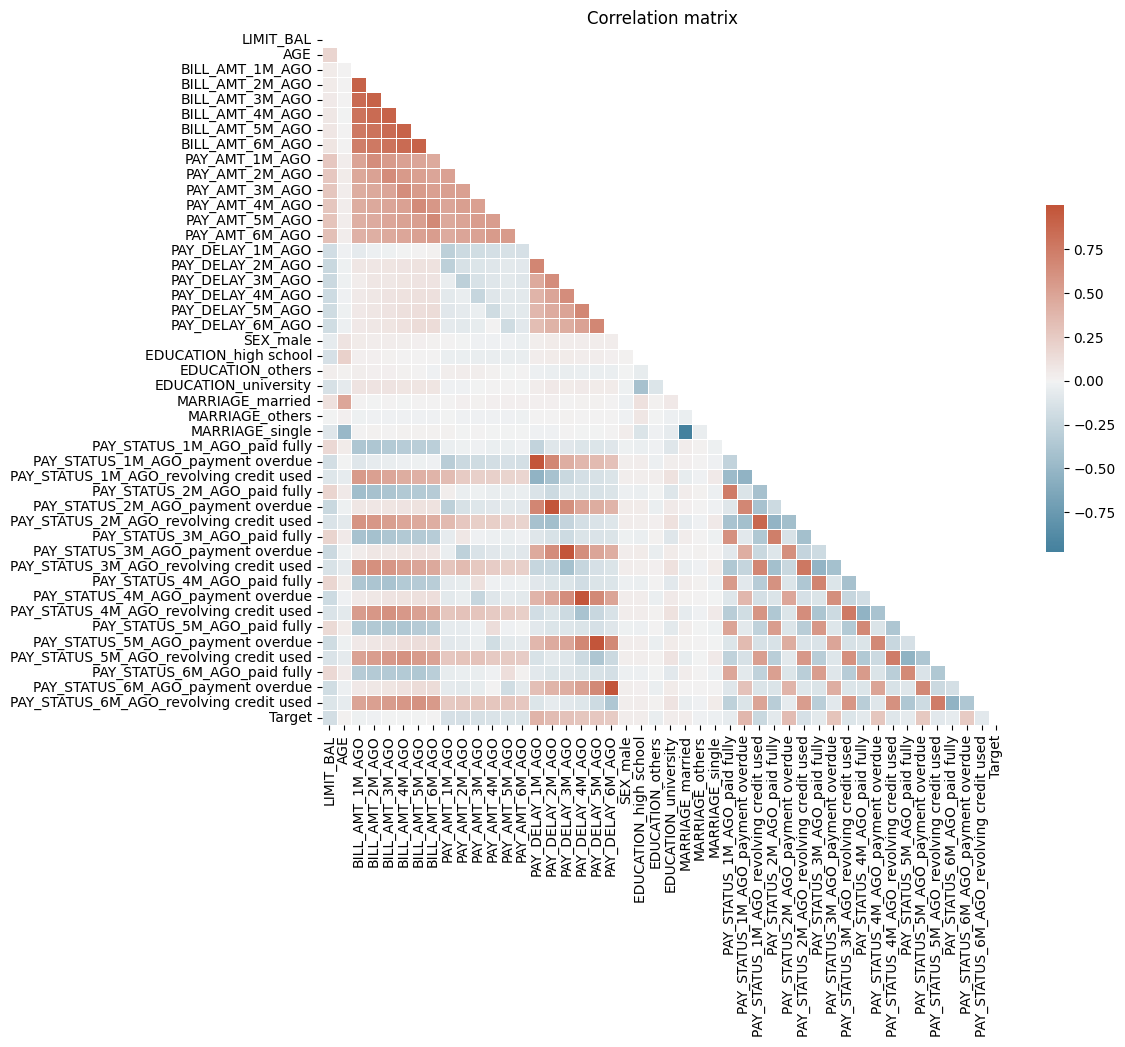

In [ ]:
default_cc_corr = calculate_correlation(default_cc_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(default_cc_corr['Target']).sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.392720
PAY_STATUS_1M_AGO_payment overdue          0.368905
PAY_DELAY_2M_AGO                           0.341986
PAY_STATUS_2M_AGO_payment overdue          0.341365
PAY_DELAY_3M_AGO                           0.297958
PAY_STATUS_3M_AGO_payment overdue          0.297067
PAY_DELAY_4M_AGO                           0.277398
PAY_STATUS_4M_AGO_payment overdue          0.276316
PAY_DELAY_5M_AGO                           0.266578
PAY_STATUS_5M_AGO_payment overdue          0.265733
PAY_DELAY_6M_AGO                           0.246007
PAY_STATUS_6M_AGO_payment overdue          0.244833
PAY_STATUS_1M_AGO_revolving credit used    0.220799
LIMIT_BAL                                  0.172015
PAY_AMT_1M_AGO                             0.157716
PAY_STATUS_2M_AGO_revolving credit used    0.154934
PAY_AMT_2M_AGO                             0.151557
PAY_AMT_3M_AGO                             0.144366
PAY_AMT_4M_AGO                             0.131908
PAY_AMT_6M_AGO                             0.126817
PAY_AMT_5M_AGO                             0.121490
PAY_STATUS_3M_AGO_revolving credit used    0.116902
PAY_STATUS_4M_AGO_revolving credit used    0.097269
PAY_STATUS_5M_AGO_revolving credit used    0.085675
PAY_STATUS_6M_AGO_revolving credit used    0.085620
PAY_STATUS_3M_AGO_paid fully               0.080234
PAY_STATUS_2M_AGO_paid fully               0.077944
PAY_STATUS_4M_AGO_paid fully               0.075880
PAY_STATUS_5M_AGO_paid fully               0.070530
PAY_STATUS_6M_AGO_paid fully               0.063240
PAY_STATUS_1M_AGO_paid fully               0.062672
EDUCATION_others                           0.047727
SEX_male                                   0.042538
EDUCATION_university                       0.038639
MARRIAGE_single                            0.033319
EDUCATION_high school                      0.032766
MARRIAGE_married                           0.031977
BILL_AMT_1M_AGO                            0.022239
MARRIAGE_others                            0.014870
BILL_AMT_2M_AGO                            0.011566
BILL_AMT_3M_AGO                            0.009081
BILL_AMT_5M_AGO                            0.007565
AGE                                        0.007317
BILL_AMT_4M_AGO                            0.006854
BILL_AMT_6M_AGO                            0.003389
Name: Target, dtype: float64

df columns:  Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4

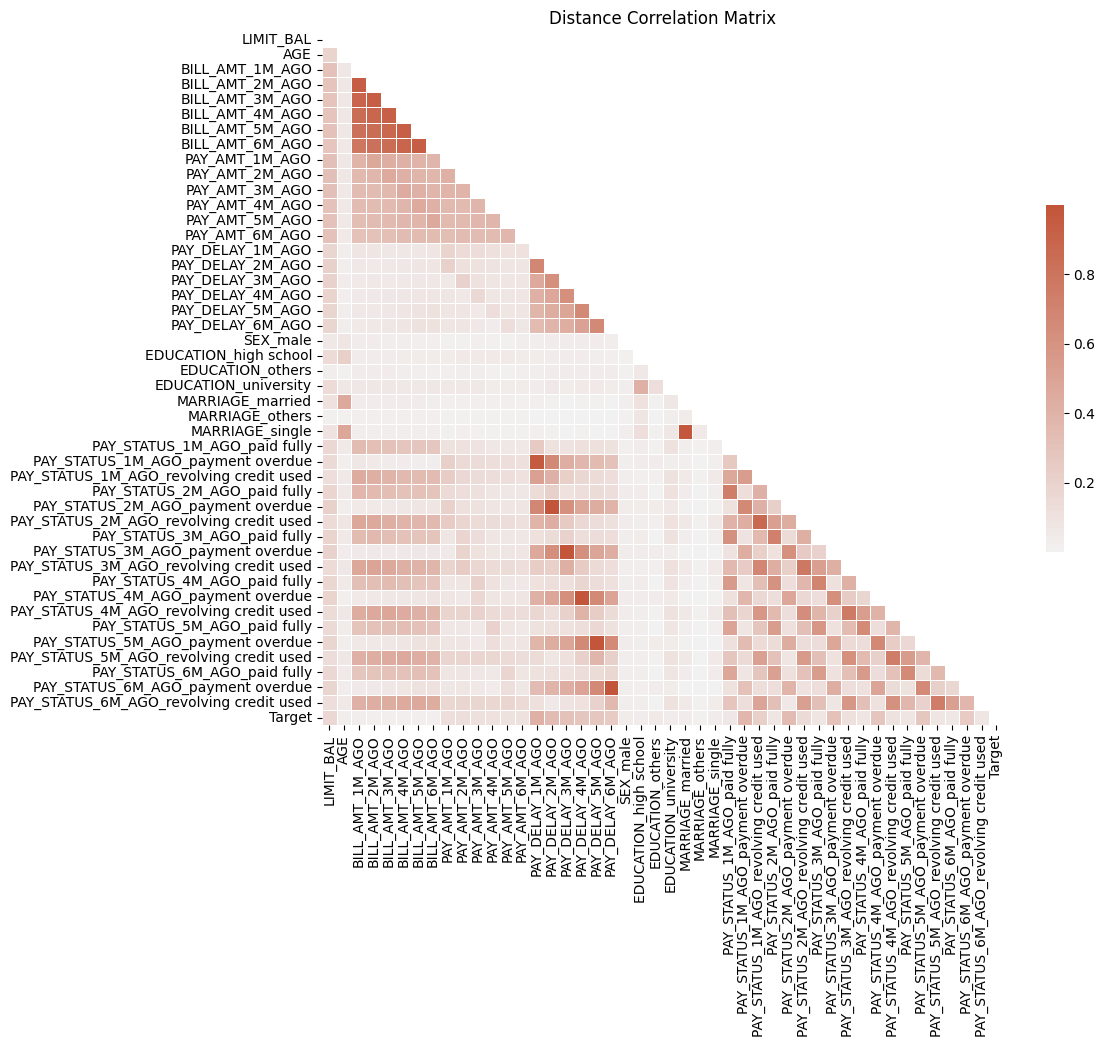

In [ ]:
# NOTE: for any two binary values it returns the abs value of spearman correlation. For numerical variables it returns different values.
default_cc_dist_corr = calculate_distance_correlation_matrix(default_cc_train_encoded)

In [ ]:
default_cc_dist_corr['Target'].sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.408897
PAY_STATUS_1M_AGO_payment overdue          0.368905
PAY_DELAY_2M_AGO                           0.342042
PAY_STATUS_2M_AGO_payment overdue          0.341365
PAY_DELAY_3M_AGO                           0.297364
PAY_STATUS_3M_AGO_payment overdue          0.297067
PAY_DELAY_4M_AGO                           0.276748
PAY_STATUS_4M_AGO_payment overdue          0.276316
PAY_DELAY_5M_AGO                           0.266163
PAY_STATUS_5M_AGO_payment overdue          0.265733
PAY_DELAY_6M_AGO                           0.245567
PAY_STATUS_6M_AGO_payment overdue          0.244833
PAY_STATUS_1M_AGO_revolving credit used    0.220799
LIMIT_BAL                                  0.159098
PAY_STATUS_2M_AGO_revolving credit used    0.154934
PAY_AMT_1M_AGO                             0.123355
PAY_AMT_2M_AGO                             0.120780
PAY_STATUS_3M_AGO_revolving credit used    0.116902
PAY_AMT_3M_AGO                             0.113377
PAY_AMT_4M_AGO                             0.101540
PAY_AMT_5M_AGO                             0.098456
PAY_STATUS_4M_AGO_revolving credit used    0.097269
PAY_AMT_6M_AGO                             0.095423
PAY_STATUS_5M_AGO_revolving credit used    0.085675
PAY_STATUS_6M_AGO_revolving credit used    0.085620
PAY_STATUS_3M_AGO_paid fully               0.080234
PAY_STATUS_2M_AGO_paid fully               0.077944
PAY_STATUS_4M_AGO_paid fully               0.075880
PAY_STATUS_5M_AGO_paid fully               0.070530
PAY_STATUS_6M_AGO_paid fully               0.063240
PAY_STATUS_1M_AGO_paid fully               0.062672
EDUCATION_others                           0.047727
SEX_male                                   0.042538
EDUCATION_university                       0.038639
MARRIAGE_single                            0.033319
EDUCATION_high school                      0.032766
MARRIAGE_married                           0.031977
AGE                                        0.027052
BILL_AMT_1M_AGO                            0.026993
BILL_AMT_2M_AGO                            0.021758
BILL_AMT_3M_AGO                            0.020607
BILL_AMT_4M_AGO                            0.018816
BILL_AMT_5M_AGO                            0.018693
BILL_AMT_6M_AGO                            0.016738
MARRIAGE_others                            0.014870
Name: Target, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

default_cc_zero_variance_columns = identify_zero_variance_columns(default_cc_train_encoded)

if DROP_WEAK_FEATURES:
  default_cc_weak_features = identify_weak_associated_features(
      default_cc_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  default_cc_weak_features = []

remove_columns = set(default_cc_zero_variance_columns + default_cc_weak_features)
print(remove_columns)

default_cc_train = default_cc_train_encoded.drop(columns=remove_columns)
default_cc_test = default_cc_test_encoded.drop(columns=remove_columns)

Variance of each column:
LIMIT_BAL                                  1.690062e+10
AGE                                        8.511344e+01
BILL_AMT_1M_AGO                            5.416491e+09
BILL_AMT_2M_AGO                            5.061538e+09
BILL_AMT_3M_AGO                            4.805235e+09
BILL_AMT_4M_AGO                            4.147691e+09
BILL_AMT_5M_AGO                            3.694314e+09
BILL_AMT_6M_AGO                            3.540063e+09
PAY_AMT_1M_AGO                             2.558793e+08
PAY_AMT_2M_AGO                             5.352601e+08
PAY_AMT_3M_AGO                             2.866536e+08
PAY_AMT_4M_AGO                             2.416386e+08
PAY_AMT_5M_AGO                             2.440565e+08
PAY_AMT_6M_AGO                             3.358963e+08
PAY_DELAY_1M_AGO                           5.816560e-01
PAY_DELAY_2M_AGO                           6.501538e-01
PAY_DELAY_3M_AGO                           6.321474e-01
PAY_DELAY_4M_AGO       

In [ ]:
default_cc_train.head()

LIMIT_BAL   AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
15971   260000.0  44.0         148803.0         137561.0         130539.0   
26684    20000.0  25.0          19099.0          18114.0          18437.0   
22140   230000.0  25.0          50757.0          52906.0          54454.0   
12105   200000.0  59.0         180887.0         166921.0         155945.0   
3839     50000.0  28.0          28129.0          29184.0          28421.0   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
15971         112300.0         105517.0         108011.0          5100.0   
26684          19267.0          19696.0          16876.0             0.0   
22140          53457.0          55128.0          52788.0          3000.0   
12105         109271.0          36753.0          78079.0         10000.0   
3839           28751.0          30685.0          30040.0          1800.0   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
15971          5300.0  ...                           0.0   
26684          1370.0  ...                           0.0   
22140          3000.0  ...                           0.0   
12105         30000.0  ...                           0.0   
3839              0.0  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 0.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
15971                                      1.0                           0.0   
26684                                      1.0                           0.0   
22140                                      1.0                           0.0   
12105                                      1.0                           0.0   
3839                                       1.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
15971                                      1.0                           0.0   
26684                                      1.0                           0.0   
22140                                      1.0                           0.0   
12105                                      1.0                           0.0   
3839                                       1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 1.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
15971                                      1.0     0.0  
26684                                      1.0     0.0  
22140                                      1.0     0.0  
12105                                      1.0     0.0  
3839                                       0.0     1.0  

[5 rows x 46 columns]

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Number of features after pre-feature selection: ', len(default_cc_train.columns))

Original number of features:  30
Number of features after pre-feature selection:  46


# **Imbalanced dataset**

In [ ]:
X_train = default_cc_train.drop('Target', axis=1)
y_train = default_cc_train['Target']

X_test = default_cc_test.drop('Target', axis=1)
y_test = default_cc_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0     18691    0.778792
1.0      5309    0.221208

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
default_cc_imputation_values_dict = calculate_imputation_values_for_missing(
    default_cc_train
)
default_cc_imputation_values_dict

{'LIMIT_BAL': 140000.0,
 'AGE': 34.0,
 'BILL_AMT_1M_AGO': 22137.0,
 'BILL_AMT_2M_AGO': 20952.5,
 'BILL_AMT_3M_AGO': 20009.5,
 'BILL_AMT_4M_AGO': 18940.5,
 'BILL_AMT_5M_AGO': 17926.0,
 'BILL_AMT_6M_AGO': 16862.5,
 'PAY_AMT_1M_AGO': 2100.0,
 'PAY_AMT_2M_AGO': 2003.0,
 'PAY_AMT_3M_AGO': 1800.0,
 'PAY_AMT_4M_AGO': 1500.0,
 'PAY_AMT_5M_AGO': 1500.0,
 'PAY_AMT_6M_AGO': 1500.0,
 'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_married': 0.0,
 'MARRIAGE_others': 0.0,
 'MARRIAGE_single': 1.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_payment overdue': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_payment overdue': 0.0,
 'PAY_STATUS_2M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid full

In [ ]:
default_cc_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
default_cc_cat_vars

['SEX_male',
 'EDUCATION_high school',
 'EDUCATION_others',
 'EDUCATION_university',
 'MARRIAGE_married',
 'MARRIAGE_others',
 'MARRIAGE_single',
 'PAY_STATUS_1M_AGO_paid fully',
 'PAY_STATUS_1M_AGO_payment overdue',
 'PAY_STATUS_1M_AGO_revolving credit used',
 'PAY_STATUS_2M_AGO_paid fully',
 'PAY_STATUS_2M_AGO_payment overdue',
 'PAY_STATUS_2M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_paid fully',
 'PAY_STATUS_3M_AGO_payment overdue',
 'PAY_STATUS_3M_AGO_revolving credit used',
 'PAY_STATUS_4M_AGO_paid fully',
 'PAY_STATUS_4M_AGO_payment overdue',
 'PAY_STATUS_4M_AGO_revolving credit used',
 'PAY_STATUS_5M_AGO_paid fully',
 'PAY_STATUS_5M_AGO_payment overdue',
 'PAY_STATUS_5M_AGO_revolving credit used',
 'PAY_STATUS_6M_AGO_paid fully',
 'PAY_STATUS_6M_AGO_payment overdue',
 'PAY_STATUS_6M_AGO_revolving credit used']

In [ ]:
# Maximum number of original features (after feature engineering) to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [4],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:10:52.189471

Nested Cross-validation Results:
Individual scores: [0.53270292 0.52562071 0.51904017]
Average nested CV score: 0.526 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.526
2025-01-18 15:10:53.048168

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-17 11:42:10.195670

Nested Cross-validation Results:
Individual scores: [0.52342409 0.52880991 0.51455823]
Average nested CV score: 0.522 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.526
2025-01-17 11:43:01.107426

Execution time: 0.85 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28  PAY_STATUS_1M_AGO_payment overdue    0.138111  0.003865
34  PAY_STATUS_3M_AGO_payment overdue    0.015316  0.001871
36       PAY_STATUS_4M_AGO_paid fully    0.009420  0.001202
17                   PAY_DELAY_4M_AGO    0.003703  0.000441
18                   PAY_DELAY_5M_AGO    0.003472  0.000114
14                   PAY_DELAY_1M_AGO    0.002079  0.000239
11                     PAY_AMT_4M_AGO    0.000691  0.000461
9                      PAY_AMT_2M_AGO   -0.000006  0.001028

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

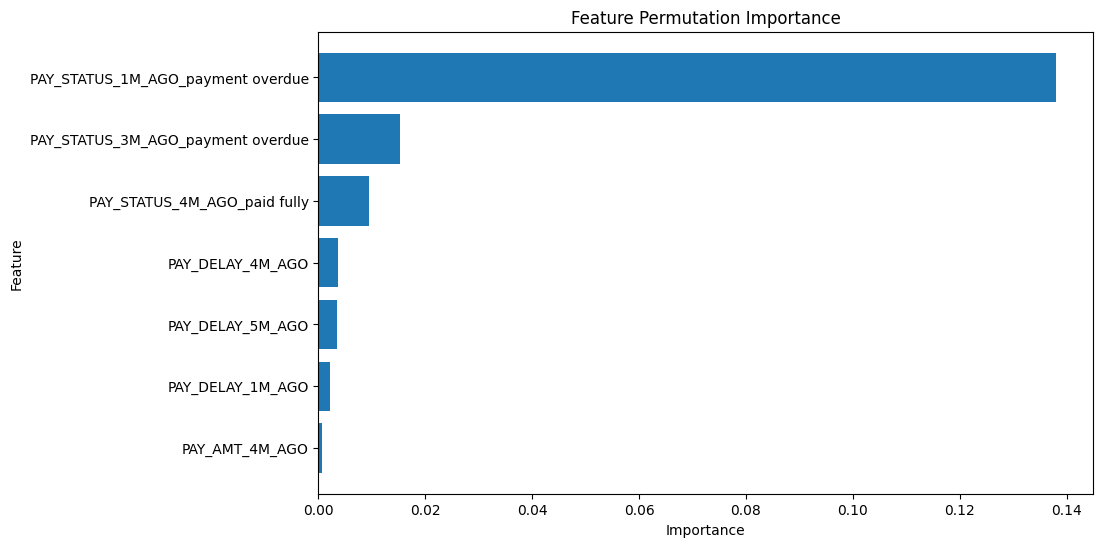

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment overdue', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO',

In [ ]:
dt_orig_missing

['PAY_STATUS_1M_AGO',
 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO',
 'PAY_DELAY_4M_AGO',
 'PAY_DELAY_5M_AGO',
 'PAY_DELAY_1M_AGO',
 'PAY_AMT_4M_AGO',
 'MARRIAGE',
 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_5M_AGO',
 'PAY_STATUS_6M_AGO',
 'EDUCATION',
 'PAY_DELAY_6M_AGO',
 'PAY_AMT_6M_AGO',
 'PAY_AMT_3M_AGO',
 'BILL_AMT_2M_AGO',
 'BILL_AMT_3M_AGO',
 'BILL_AMT_4M_AGO',
 'BILL_AMT_5M_AGO',
 'BILL_AMT_6M_AGO']

In [ ]:
len(dt_missing)

36

In [ ]:
dt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1   410  4275  398   917      50.74   30.90        91.48     78.08     38.41   
2   139  4562  111  1188      55.60   10.47        97.62     78.35     17.63   
3   139  4562  111  1188      55.60   10.47        97.62     78.35     17.63   
4     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.59                 0   
1               61.19                 1   
2               54.05                 2   
3               54.05                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:11:20.492431

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
dt_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1   440  4168  505   887      46.56   33.16        89.19     76.80     38.73   
2   193  4461  212  1134      47.65   14.54        95.46     77.57     22.29   
3   169  4526  147  1158      53.48   12.74        96.85     78.25     20.57   
4   165  4532  141  1162      53.92   12.43        96.98     78.28     20.21   
5    37  4623   50  1290      42.53    2.79        98.93     77.67      5.23   
6    38  4624   49  1289      43.68    2.86        98.95     77.70      5.37   
7    34  4627   46  1293      42.50    2.56        99.02     77.68      4.83   
8    45  4590   83  1282      35.16    3.39        98.22     77.25      6.19   
9     4  4666    7  1323      36.36    0.30        99.85     77.83      0.60   
10    4  4666    7  1323      36.36    0.30        99.85     77.83      0.60   
11    4  4666    7  1323      36.36    0.30        99.85     77.83      0.60   
12    4  4666    7  1323      36.36    0.30        99.85     77.83      0.60   
13    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
14    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
15    5  4664    9  1322      35.71    0.38        99.81     77.82      0.75   
16    6  4666    7  1321      46.15    0.45        99.85     77.87      0.90   
17    6  4665    8  1321      42.86    0.45        99.83     77.85      0.89   
18    4  4666    7  1323      36.36    0.30        99.85     77.83      0.60   
19    4  4666    7  1323      36.36    0.30        99.85     77.83      0.60   
20    4  4667    6  1323      40.00    0.30        99.87     77.85      0.60   

    balanced_accuracy  num_feat_missing  \
0               69.59                 0   
1               61.18                 1   
2               55.00                 2   
3               54.79                 3   
4               54.71                 4   
5               50.86                 5   
6               50.91                 6   
7               50.79                 7   
8               50.81                 8   
9               50.08                 9   
10              50.08                10   
11              50.08                11   
12              50.08                12   
13              50.07                13   
14              50.07                14   
15              50.09                15   
16              50.15                16   
17              50.14                17   
18              50.08                18   
19              50.08                19   
20              50.09                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
dt_perf_temp, dt_orig_missing_temp, dt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
dt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1  410  4275  398   917      50.74   30.90        91.48     78.08     38.41   
2  139  4562  111  1188      55.60   10.47        97.62     78.35     17.63   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.59                 0   
1              61.19                 4   
2              54.05                 8   
3              50.00                12   
4              50.00                16   
5              50.00                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_temp_mf, dt_orig_missing_temp_mf, dt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:18:14.001270

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
dt_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1  440  4168  505   887      46.56   33.16        89.19     76.80     38.73   
2  193  4461  212  1134      47.65   14.54        95.46     77.57     22.29   
3   49  4617   56  1278      46.67    3.69        98.80     77.77      6.84   
4   23  4652   21  1304      52.27    1.73        99.55     77.92      3.36   
5   31  4646   27  1296      53.45    2.34        99.42     77.95      4.48   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.59                 0   
1              61.18                 4   
2              55.00                 8   
3              51.25                12   
4              50.64                16   
5              50.88                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [100],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:20:12.829962

Nested Cross-validation Results:
Individual scores: [0.55653072 0.5437788  0.55210819]
Average nested CV score: 0.551 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.551
2025-01-18 15:20:28.009191

Execution time: 0.25 minutes



```
Starting hyperparameter tuning at: 2025-01-18 02:42:45.170812

Nested Cross-validation Results:
Individual scores: [0.5535852  0.54224396 0.54817877]
Average nested CV score: 0.548 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.551
2025-01-18 04:25:39.163429

Execution time: 102.90 minutes
```

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.025109  0.001644
2                           BILL_AMT_1M_AGO    0.021760  0.001074
7                           BILL_AMT_6M_AGO    0.020497  0.001281
10                           PAY_AMT_3M_AGO    0.020069  0.000913
11                           PAY_AMT_4M_AGO    0.017578  0.001036
9                            PAY_AMT_2M_AGO    0.017296  0.001683
0                                 LIMIT_BAL    0.016268  0.001300
8                            PAY_AMT_1M_AGO    0.016185  0.001983
13                           PAY_AMT_6M_AGO    0.015352  0.001423
6                           BILL_AMT_5M_AGO    0.015284  0.000969
5                           BILL_AMT_4M_AGO    0.013522  0.000633
12                           PAY_AMT_5M_AGO    0.012324  0.000892
3                           BILL_AMT_2M_AGO    0.011116  0.000627
1                                       AGE    0.008030  0.000544
4                           BILL_AMT_3M_AGO    0.007809  0.000521
29  PAY_STATUS_1M_AGO_revolving credit used    0.003986  0.000633
44  PAY_STATUS_6M_AGO_revolving credit used    0.003763  0.000892
16                         PAY_DELAY_3M_AGO    0.003376  0.000795
34        PAY_STATUS_3M_AGO_payment overdue    0.002999  0.001002
42             PAY_STATUS_6M_AGO_paid fully    0.002978  0.000223
26                          MARRIAGE_single    0.002861  0.000498
20                                 SEX_male    0.002789  0.000133
32  PAY_STATUS_2M_AGO_revolving credit used    0.002586  0.000733
39             PAY_STATUS_5M_AGO_paid fully    0.002494  0.000438
28        PAY_STATUS_1M_AGO_payment overdue    0.002443  0.000473
30             PAY_STATUS_2M_AGO_paid fully    0.002290  0.000343
41  PAY_STATUS_5M_AGO_revolving credit used    0.002082  0.000219
23                     EDUCATION_university    0.001946  0.000534
33             PAY_STATUS_3M_AGO_paid fully    0.001818  0.000317
35  PAY_STATUS_3M_AGO_revolving credit used    0.001739  0.000573
36             PAY_STATUS_4M_AGO_paid fully    0.001699  0.000378
37        PAY_STATUS_4M_AGO_payment overdue    0.001655  0.000529
24                         MARRIAGE_married    0.001620  0.000382
27             PAY_STATUS_1M_AGO_paid fully    0.001242  0.000292
21                    EDUCATION_high school    0.001165  0.000161
22                         EDUCATION_others    0.001050  0.000330
18                         PAY_DELAY_5M_AGO    0.000816  0.000306
17                         PAY_DELAY_4M_AGO    0.000736  0.000568
43        PAY_STATUS_6M_AGO_payment overdue    0.000685  0.000675
38  PAY_STATUS_4M_AGO_revolving credit used    0.000506  0.000523
19                         PAY_DELAY_6M_AGO    0.000478  0.000464
31        PAY_STATUS_2M_AGO_payment overdue    0.000274  0.000933
25                          MARRIAGE_others    0.000172  0.000000
40        PAY_STATUS_5M_AGO_payment overdue   -0.000255  0.000150
15                         PAY_DELAY_2M_AGO   -0.002355  0.001638

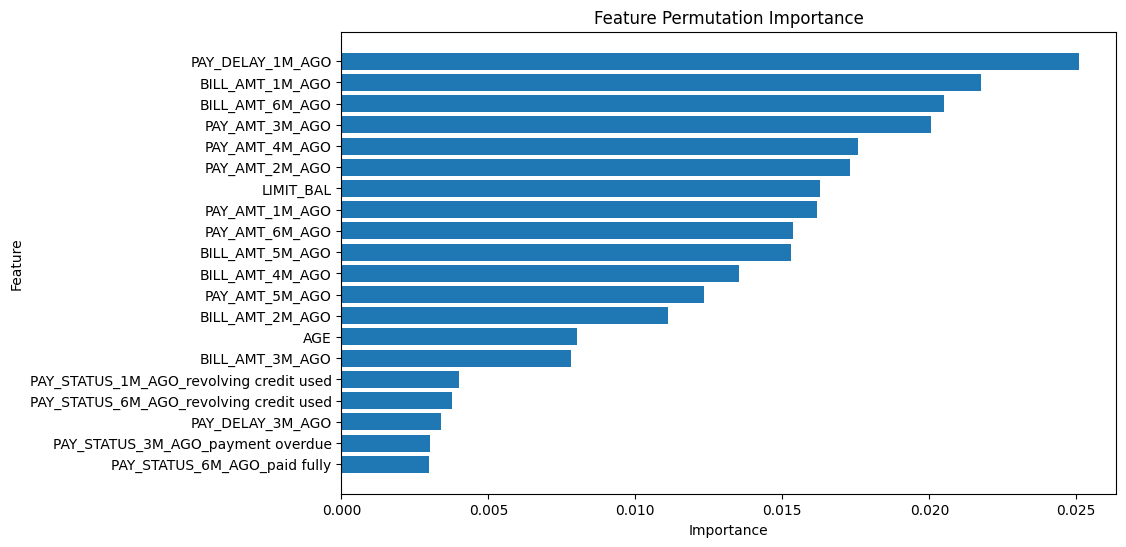

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_6M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original fe

In [ ]:
rf_perf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   767  3926  747  560      50.66   57.80        84.01     78.22     54.00   
1   694  3991  682  633      50.44   52.30        85.41     78.08     51.35   
2   626  4123  550  701      53.23   47.17        88.23     79.15     50.02   
3   609  4148  525  718      53.70   45.89        88.77     79.28     49.49   
4   589  4164  509  738      53.64   44.39        89.11     79.22     48.58   
5   582  4176  497  745      53.94   43.86        89.36     79.30     48.38   
6   572  4189  484  755      54.17   43.10        89.64     79.35     48.01   
7   566  4193  480  761      54.11   42.65        89.73     79.32     47.70   
8   558  4190  483  769      53.60   42.05        89.66     79.13     47.13   
9   560  4193  480  767      53.85   42.20        89.73     79.22     47.32   
10  563  4200  473  764      54.34   42.43        89.88     79.38     47.65   
11  564  4197  476  763      54.23   42.50        89.81     79.35     47.66   
12  564  4193  480  763      54.02   42.50        89.73     79.28     47.57   
13  559  4204  469  768      54.38   42.13        89.96     79.38     47.47   
14  558  4208  465  769      54.55   42.05        90.05     79.43     47.49   
15  564  4191  482  763      53.92   42.50        89.69     79.25     47.53   
16  533  4205  468  794      53.25   40.17        89.99     78.97     45.79   
17  518  4225  448  809      53.62   39.04        90.41     79.05     45.18   
18  503  4248  425  824      54.20   37.91        90.91     79.18     44.61   
19  520  4221  452  807      53.50   39.19        90.33     79.02     45.24   
20  518  4224  449  809      53.57   39.04        90.39     79.03     45.16   

    balanced_accuracy  num_feat_missing  \
0               70.91                 0   
1               68.85                 1   
2               67.70                 2   
3               67.33                 3   
4               66.75                 4   
5               66.61                 5   
6               66.37                 6   
7               66.19                 7   
8               65.86                 8   
9               65.96                 9   
10              66.15                10   
11              66.16                11   
12              66.12                12   
13              66.04                13   
14              66.05                14   
15              66.09                15   
16              65.08                16   
17              64.72                17   
18              64.41                18   
19              64.76                19   
20              64.71                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:20:43.166386

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
rf_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   767  3926  747  560      50.66   57.80        84.01     78.22     54.00   
1   706  3964  709  621      49.89   53.20        84.83     77.83     51.50   
2   676  4023  650  651      50.98   50.94        86.09     78.32     50.96   
3   665  4046  627  662      51.47   50.11        86.58     78.52     50.78   
4   644  4090  583  683      52.49   48.53        87.52     78.90     50.43   
5   618  4134  539  709      53.41   46.57        88.47     79.20     49.76   
6   609  4156  517  718      54.09   45.89        88.94     79.42     49.65   
7   593  4171  502  734      54.16   44.69        89.26     79.40     48.97   
8   576  4184  489  751      54.08   43.41        89.54     79.33     48.16   
9   566  4195  478  761      54.21   42.65        89.77     79.35     47.74   
10  558  4202  471  769      54.23   42.05        89.92     79.33     47.37   
11  559  4217  456  768      55.07   42.13        90.24     79.60     47.74   
12  559  4219  454  768      55.18   42.13        90.28     79.63     47.78   
13  540  4233  440  787      55.10   40.69        90.58     79.55     46.81   
14  539  4240  433  788      55.45   40.62        90.73     79.65     46.89   
15  574  4176  497  753      53.59   43.26        89.36     79.17     47.87   
16  585  4106  567  742      50.78   44.08        87.87     78.18     47.20   
17  570  4129  544  757      51.17   42.95        88.36     78.32     46.70   
18  560  4159  514  767      52.14   42.20        89.00     78.65     46.65   
19  551  4163  510  776      51.93   41.52        89.09     78.57     46.15   
20  548  4166  507  779      51.94   41.30        89.15     78.57     46.01   

    balanced_accuracy  num_feat_missing  \
0               70.91                 0   
1               69.02                 1   
2               68.52                 2   
3               68.35                 3   
4               68.03                 4   
5               67.52                 5   
6               67.41                 6   
7               66.97                 7   
8               66.47                 8   
9               66.21                 9   
10              65.99                10   
11              66.18                11   
12              66.20                12   
13              65.64                13   
14              65.68                14   
15              66.31                15   
16              65.98                16   
17              65.66                17   
18              65.60                18   
19              65.30                19   
20              65.22                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'BILL_...

In [ ]:
rf_perf_temp, rf_orig_missing_temp, rf_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
rf_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  767  3926  747   560      50.66   57.80        84.01     78.22     54.00   
1  546  4171  502   781      52.10   41.15        89.26     78.62     45.98   
2  522  4202  471   805      52.57   39.34        89.92     78.73     45.00   
3  466  4275  398   861      53.94   35.12        91.48     79.02     42.54   
4  420  4346  327   907      56.22   31.65        93.00     79.43     40.50   
5    7  4667    6  1320      53.85    0.53        99.87     77.90      1.04   

   balanced_accuracy  num_feat_missing  \
0              70.91                 0   
1              65.20                 4   
2              64.63                 8   
3              63.30                12   
4              62.33                16   
5              50.20                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_temp_mf, rf_orig_missing_temp_mf, rf_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:27:19.608860

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
rf_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  767  3926  747   560      50.66   57.80        84.01     78.22     54.00   
1  599  4083  590   728      50.38   45.14        87.37     78.03     47.62   
2  567  4154  519   760      52.21   42.73        88.89     78.68     47.00   
3  518  4219  454   809      53.29   39.04        90.28     78.95     45.06   
4  454  4299  374   873      54.83   34.21        92.00     79.22     42.13   
5   60  4636   37  1267      61.86    4.52        99.21     78.27      8.43   

   balanced_accuracy  num_feat_missing  \
0              70.91                 0   
1              66.26                 4   
2              65.81                 8   
3              64.66                12   
4              63.10                16   
5              51.86                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

3.520625353173856

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [100],
      'min_split_gain': [0.5],
      'reg_lambda': [0.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:29:03.426332

Nested Cross-validation Results:
Individual scores: [0.54140277 0.54385105 0.54611299]
Average nested CV score: 0.544 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.544
2025-01-18 15:29:07.665322

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 11:43:01.135200

Nested Cross-validation Results:
Individual scores: [0.53342716 0.54006371 0.54125571]
Average nested CV score: 0.538 (+/- 0.007)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.544
2025-01-17 11:54:43.888904

Execution time: 11.71 minutes
```

In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.090436  0.000802
0                                 LIMIT_BAL    0.014657  0.001518
16                         PAY_DELAY_3M_AGO    0.007824  0.001235
4                           BILL_AMT_3M_AGO    0.007418  0.001153
15                         PAY_DELAY_2M_AGO    0.006711  0.001433
2                           BILL_AMT_1M_AGO    0.006647  0.001620
3                           BILL_AMT_2M_AGO    0.004581  0.000529
11                           PAY_AMT_4M_AGO    0.004076  0.001388
10                           PAY_AMT_3M_AGO    0.003478  0.000837
27             PAY_STATUS_1M_AGO_paid fully    0.003399  0.000608
5                           BILL_AMT_4M_AGO    0.002731  0.000620
9                            PAY_AMT_2M_AGO    0.002599  0.000818
17                         PAY_DELAY_4M_AGO    0.002498  0.000397
22                         EDUCATION_others    0.002475  0.000551
19                         PAY_DELAY_6M_AGO    0.002193  0.000996
26                          MARRIAGE_single    0.002189  0.000895
36             PAY_STATUS_4M_AGO_paid fully    0.001890  0.000606
20                                 SEX_male    0.001811  0.000894
18                         PAY_DELAY_5M_AGO    0.001123  0.000731
1                                       AGE    0.000987  0.000478
6                           BILL_AMT_5M_AGO    0.000962  0.000514
13                           PAY_AMT_6M_AGO    0.000953  0.001031
8                            PAY_AMT_1M_AGO    0.000738  0.001339
23                     EDUCATION_university    0.000323  0.000209
39             PAY_STATUS_5M_AGO_paid fully    0.000190  0.000140
33             PAY_STATUS_3M_AGO_paid fully    0.000027  0.000046
12                           PAY_AMT_5M_AGO    0.000009  0.000836
24                         MARRIAGE_married   -0.000048  0.000289
44  PAY_STATUS_6M_AGO_revolving credit used   -0.000078  0.000072
42             PAY_STATUS_6M_AGO_paid fully   -0.000148  0.000082
7                           BILL_AMT_6M_AGO   -0.000477  0.001078
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000668  0.000484

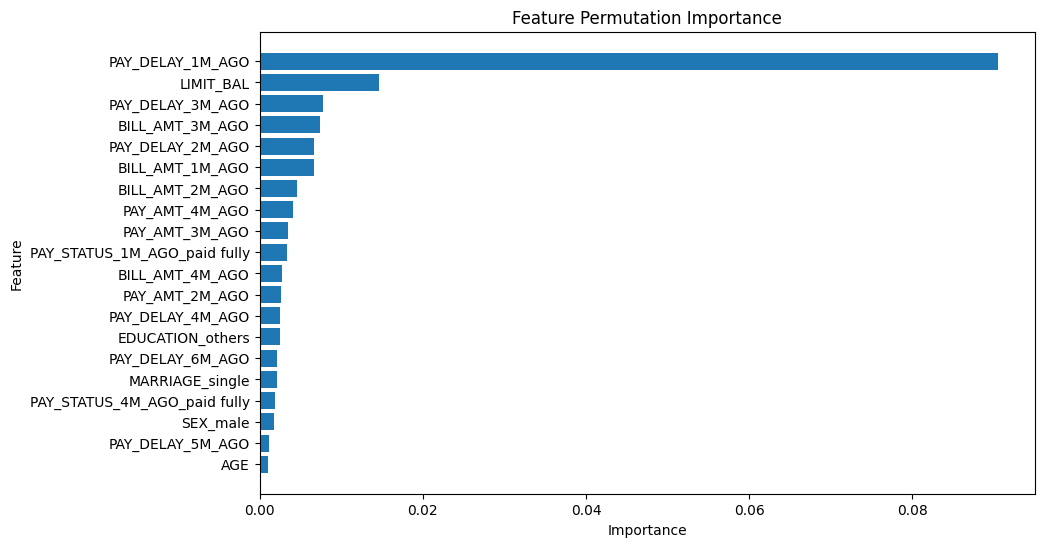

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_3M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_3M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_2M_AGO
Original feat removed so

In [ ]:
gbt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3737  936   505      46.76   61.94        79.97     75.98     53.29   
1   629  3921  752   698      45.55   47.40        83.91     75.83     46.45   
2   611  3979  694   716      46.82   46.04        85.15     76.50     46.43   
3   539  4071  602   788      47.24   40.62        87.12     76.83     43.68   
4   528  4065  608   799      46.48   39.79        86.99     76.55     42.87   
5   431  4157  516   896      45.51   32.48        88.96     76.47     37.91   
6   270  4473  200  1057      57.45   20.35        95.72     79.05     30.05   
7   281  4451  222  1046      55.86   21.18        95.25     78.87     30.71   
8   223  4523  150  1104      59.79   16.80        96.79     79.10     26.24   
9   184  4574   99  1143      65.02   13.87        97.88     79.30     22.86   
10  180  4573  100  1147      64.29   13.56        97.86     79.22     22.40   
11  171  4578   95  1156      64.29   12.89        97.97     79.15     21.47   
12  195  4556  117  1132      62.50   14.69        97.50     79.18     23.79   
13   23  4661   12  1304      65.71    1.73        99.74     78.07      3.38   
14   23  4661   12  1304      65.71    1.73        99.74     78.07      3.38   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.96                 0   
1               65.65                 1   
2               65.60                 2   
3               63.87                 3   
4               63.39                 4   
5               60.72                 5   
6               58.03                 6   
7               58.21                 7   
8               56.80                 8   
9               55.87                 9   
10              55.71                10   
11              55.43                11   
12              56.10                12   
13              50.74                13   
14              50.74                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:29:12.979890

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
gbt_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    822  3737   936  505      46.76   61.94        79.97     75.98     53.29   
1   1013  2549  2124  314      32.29   76.34        54.55     59.37     45.39   
2    959  2772  1901  368      33.53   72.27        59.32     62.18     45.81   
3    946  2812  1861  381      33.70   71.29        60.18     62.63     45.77   
4    953  2818  1855  374      33.94   71.82        60.30     62.85     46.09   
5    904  2872  1801  423      33.42   68.12        61.46     62.93     44.84   
6    771  3261  1412  556      35.32   58.10        69.78     67.20     43.93   
7    762  3324  1349  565      36.10   57.42        71.13     68.10     44.33   
8    730  3436  1237  597      37.11   55.01        73.53     69.43     44.32   
9    652  3717   956  675      40.55   49.13        79.54     72.82     44.43   
10   791  3133  1540  536      33.93   59.61        67.04     65.40     43.25   
11   794  3137  1536  533      34.08   59.83        67.13     65.52     43.42   
12   733  3188  1485  594      33.05   55.24        68.22     65.35     41.35   
13   856  2654  2019  471      29.77   64.51        56.79     58.50     40.74   
14   853  2641  2032  474      29.57   64.28        56.52     58.23     40.50   
15  1048  1683  2990  279      25.95   78.98        36.02     45.52     39.07   
16   996  1867  2806  331      26.20   75.06        39.95     47.72     38.84   
17  1039  1611  3062  288      25.34   78.30        34.47     44.17     38.28   
18  1032  1570  3103  295      24.96   77.77        33.60     43.37     37.79   
19  1082  1191  3482  245      23.71   81.54        25.49     37.88     36.73   
20  1080  1285  3388  247      24.17   81.39        27.50     39.42     37.27   

    balanced_accuracy  num_feat_missing  \
0               70.96                 0   
1               65.44                 1   
2               65.79                 2   
3               65.73                 3   
4               66.06                 4   
5               64.79                 5   
6               63.94                 6   
7               64.28                 7   
8               64.27                 8   
9               64.34                 9   
10              63.33                10   
11              63.48                11   
12              61.73                12   
13              60.65                13   
14              60.40                14   
15              57.50                15   
16              57.50                16   
17              56.39                17   
18              55.68                18   
19              53.51                19   
20              54.44                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
gbt_perf_temp, gbt_orig_missing_temp, gbt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
gbt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  822  3737  936   505      46.76   61.94        79.97     75.98     53.29   
1  475  4243  430   852      52.49   35.80        90.80     78.63     42.56   
2  457  4290  383   870      54.40   34.44        91.80     79.12     42.18   
3  328  4459  214   999      60.52   24.72        95.42     79.78     35.10   
4  243  4522  151  1084      61.68   18.31        96.77     79.42     28.24   
5   16  4662   11  1311      59.26    1.21        99.76     77.97      2.36   
6   14  4663   10  1313      58.33    1.06        99.79     77.95      2.07   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.96                 0   
1              63.30                 4   
2              63.12                 5   
3              60.07                 9   
4              57.54                13   
5              50.49                17   
6              50.42                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_temp_mf, gbt_orig_missing_temp_mf, gbt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:35:55.242657

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
gbt_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3737   936  505      46.76   61.94        79.97     75.98     53.29   
1  1028  2233  2440  299      29.64   77.47        47.79     54.35     42.88   
2  1017  2328  2345  310      30.25   76.64        49.82     55.75     43.38   
3   959  2540  2133  368      31.02   72.27        54.35     58.32     43.40   
4   771  2962  1711  556      31.06   58.10        63.39     62.22     40.48   
5   947  2153  2520  380      27.31   71.36        46.07     51.67     39.51   
6   952  2115  2558  375      27.12   71.74        45.26     51.12     39.36   
7  1140  1030  3643  187      23.83   85.91        22.04     36.17     37.32   

   balanced_accuracy  num_feat_missing  \
0              70.96                 0   
1              62.63                 4   
2              63.23                 5   
3              63.31                 9   
4              60.74                13   
5              58.72                17   
6              58.50                18   
7              53.97                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[1.0],
      'gamma': [1.0],
      'colsample_bytree':[0.75]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:38:12.714205

Nested Cross-validation Results:
Individual scores: [0.53612615 0.53740831 0.54044834]
Average nested CV score: 0.538 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 1.0}

Best Model Performance:
Best CV score: 0.538
2025-01-18 15:38:16.118832

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 11:54:43.911105

Nested Cross-validation Results:
Individual scores: [0.52972973 0.53288364 0.53193016]
Average nested CV score: 0.532 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 1.0}

Best Model Performance:
Best CV score: 0.538
2025-01-17 12:18:46.104509

Execution time: 24.04 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.079455  0.001870
0                                 LIMIT_BAL    0.016745  0.001244
2                           BILL_AMT_1M_AGO    0.010804  0.002013
4                           BILL_AMT_3M_AGO    0.008377  0.001310
27             PAY_STATUS_1M_AGO_paid fully    0.005290  0.000829
3                           BILL_AMT_2M_AGO    0.005015  0.001139
5                           BILL_AMT_4M_AGO    0.004199  0.000452
31        PAY_STATUS_2M_AGO_payment overdue    0.003524  0.001397
9                            PAY_AMT_2M_AGO    0.002567  0.001119
34        PAY_STATUS_3M_AGO_payment overdue    0.002566  0.001278
20                                 SEX_male    0.002465  0.000528
11                           PAY_AMT_4M_AGO    0.002334  0.002000
37        PAY_STATUS_4M_AGO_payment overdue    0.001966  0.000836
1                                       AGE    0.001907  0.000860
7                           BILL_AMT_6M_AGO    0.001880  0.001467
22                         EDUCATION_others    0.001832  0.000317
16                         PAY_DELAY_3M_AGO    0.001825  0.001416
10                           PAY_AMT_3M_AGO    0.001794  0.001277
28        PAY_STATUS_1M_AGO_payment overdue    0.001559  0.001577
19                         PAY_DELAY_6M_AGO    0.001341  0.001452
18                         PAY_DELAY_5M_AGO    0.001121  0.001013
8                            PAY_AMT_1M_AGO    0.001029  0.001608
15                         PAY_DELAY_2M_AGO    0.000942  0.000325
29  PAY_STATUS_1M_AGO_revolving credit used    0.000917  0.000332
25                          MARRIAGE_others    0.000832  0.000147
12                           PAY_AMT_5M_AGO    0.000824  0.000577
23                     EDUCATION_university    0.000790  0.000206
13                           PAY_AMT_6M_AGO    0.000761  0.000357
42             PAY_STATUS_6M_AGO_paid fully    0.000739  0.000276
36             PAY_STATUS_4M_AGO_paid fully    0.000654  0.000349
26                          MARRIAGE_single    0.000596  0.000791
17                         PAY_DELAY_4M_AGO    0.000592  0.000423
24                         MARRIAGE_married    0.000548  0.000603
38  PAY_STATUS_4M_AGO_revolving credit used    0.000114  0.000044
39             PAY_STATUS_5M_AGO_paid fully   -0.000040  0.000030
6                           BILL_AMT_5M_AGO   -0.000353  0.001917
33             PAY_STATUS_3M_AGO_paid fully   -0.001064  0.000635

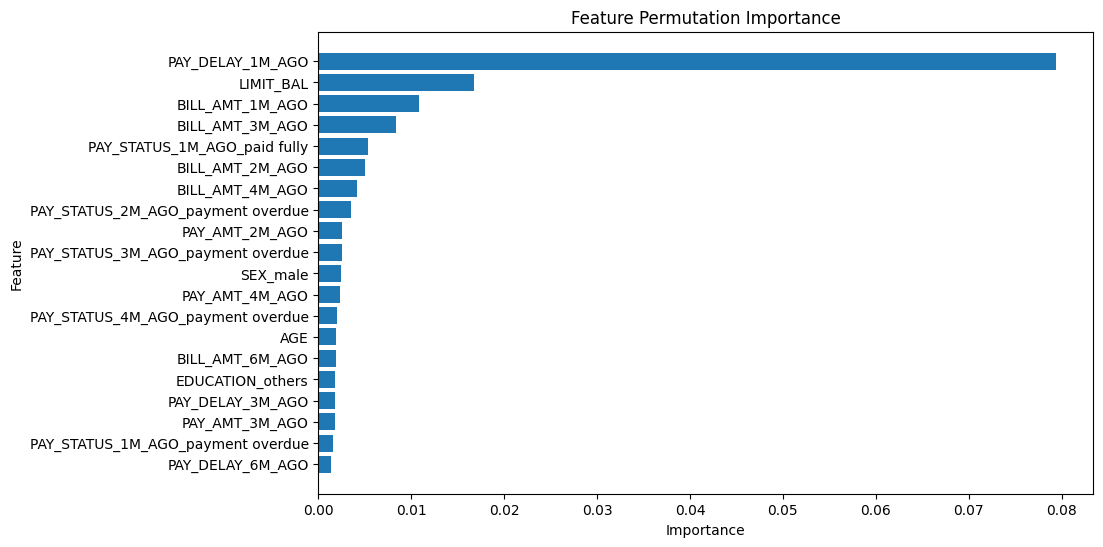

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'BILL_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'BILL_AMT_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_

In [ ]:
xgb_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   815  3757  916   512      47.08   61.42        80.40     76.20     53.30   
1   655  3942  731   672      47.26   49.36        84.36     76.62     48.29   
2   626  3957  716   701      46.65   47.17        84.68     76.38     46.91   
3   459  4291  382   868      54.58   34.59        91.83     79.17     42.34   
4   469  4283  390   858      54.60   35.34        91.65     79.20     42.91   
5   405  4383  290   922      58.27   30.52        93.79     79.80     40.06   
6   411  4381  292   916      58.46   30.97        93.75     79.87     40.49   
7   403  4392  281   924      58.92   30.37        93.99     79.92     40.08   
8   311  4462  211  1016      59.58   23.44        95.48     79.55     33.64   
9   268  4499  174  1059      60.63   20.20        96.28     79.45     30.30   
10  190  4546  127  1137      59.94   14.32        97.28     78.93     23.11   
11  172  4561  112  1155      60.56   12.96        97.60     78.88     21.35   
12  123  4614   59  1204      67.58    9.27        98.74     78.95     16.30   
13    7  4672    1  1320      87.50    0.53        99.98     77.98      1.05   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.91                 0   
1               66.86                 1   
2               65.93                 2   
3               63.21                 3   
4               63.50                 4   
5               62.16                 5   
6               62.36                 6   
7               62.18                 7   
8               59.46                 8   
9               58.24                 9   
10              55.80                10   
11              55.28                11   
12              54.00                12   
13              50.25                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:38:19.220390

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
xgb_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   815  3757  916   512      47.08   61.42        80.40     76.20     53.30   
1   713  3879  794   614      47.31   53.73        83.01     76.53     50.32   
2   672  3956  717   655      48.38   50.64        84.66     77.13     49.48   
3   610  4069  604   717      50.25   45.97        87.07     77.98     48.01   
4   574  4138  535   753      51.76   43.26        88.55     78.53     47.13   
5   606  4008  665   721      47.68   45.67        85.77     76.90     46.65   
6   639  3930  743   688      46.24   48.15        84.10     76.15     47.18   
7   659  3880  793   668      45.39   49.66        83.03     75.65     47.43   
8   670  3827  846   657      44.20   50.49        81.90     74.95     47.13   
9   567  4086  587   760      49.13   42.73        87.44     77.55     45.71   
10  570  4075  598   757      48.80   42.95        87.20     77.42     45.69   
11  543  4090  583   784      48.22   40.92        87.52     77.22     44.27   
12  509  4210  463   818      52.37   38.36        90.09     78.65     44.28   
13  490  4223  450   837      52.13   36.93        90.37     78.55     43.23   
14  470  4275  398   857      54.15   35.42        91.48     79.08     42.82   
15  470  4269  404   857      53.78   35.42        91.35     78.98     42.71   
16  476  4261  412   851      53.60   35.87        91.18     78.95     42.98   
17  396  4361  312   931      55.93   29.84        93.32     79.28     38.92   
18  377  4399  274   950      57.91   28.41        94.14     79.60     38.12   
19  328  4446  227   999      59.10   24.72        95.14     79.57     34.86   
20  192  4516  157  1135      55.01   14.47        96.64     78.47     22.91   

    balanced_accuracy  num_feat_missing  \
0               70.91                 0   
1               68.37                 1   
2               67.65                 2   
3               66.52                 3   
4               65.90                 4   
5               65.72                 5   
6               66.13                 6   
7               66.35                 7   
8               66.19                 8   
9               65.08                 9   
10              65.08                10   
11              64.22                11   
12              64.22                12   
13              63.65                13   
14              63.45                14   
15              63.39                15   
16              63.53                16   
17              61.58                17   
18              61.27                18   
19              59.93                19   
20              55.55                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
xgb_perf_temp, xgb_orig_missing_temp, xgb_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
xgb_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  815  3757  916   512      47.08   61.42        80.40     76.20     53.30   
1  437  4321  352   890      55.39   32.93        92.47     79.30     41.30   
2  408  4365  308   919      56.98   30.75        93.41     79.55     39.94   
3  298  4502  171  1029      63.54   22.46        96.34     80.00     33.18   
4  181  4567  106  1146      63.07   13.64        97.73     79.13     22.43   
5    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.91                 0   
1              62.70                 4   
2              62.08                 5   
3              59.40                 9   
4              55.69                13   
5              50.04                17   
6              50.00                18   
7              50.00                19   
8              50.00                23   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_temp_mf, xgb_orig_missing_temp_mf, xgb_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:45:02.835119

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
xgb_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  815  3757  916   512      47.08   61.42        80.40     76.20     53.30   
1  661  3895  778   666      45.93   49.81        83.35     75.93     47.79   
2  611  3982  691   716      46.93   46.04        85.21     76.55     46.48   
3  560  4132  541   767      50.86   42.20        88.42     78.20     46.13   
4  333  4407  266   994      55.59   25.09        94.31     79.00     34.58   
5  184  4559  114  1143      61.74   13.87        97.56     79.05     22.65   
6  185  4555  118  1142      61.06   13.94        97.47     79.00     22.70   
7  178  4563  110  1149      61.81   13.41        97.65     79.02     22.04   
8   58  4644   29  1269      66.67    4.37        99.38     78.37      8.20   

   balanced_accuracy  num_feat_missing  \
0              70.91                 0   
1              66.58                 4   
2              65.63                 5   
3              65.31                 9   
4              59.70                13   
5              55.71                17   
6              55.71                18   
7              55.53                19   
8              51.88                23   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:47:41.421459

Nested Cross-validation Results:
Individual scores: [0.54644809 0.53255691 0.53976269]
Average nested CV score: 0.540 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.540
2025-01-18 15:47:50.812755

Execution time: 0.16 minutes


```
Starting hyperparameter tuning at: 2025-01-17 13:47:13.368415

Nested Cross-validation Results:
Individual scores: [0.54608523 0.53393425 0.53746507]
Average nested CV score: 0.539 (+/- 0.010)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.540
2025-01-17 14:50:59.708888

Execution time: 63.77 minutes
```

In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.029795  0.000806
0                                 LIMIT_BAL    0.017122  0.001753
28        PAY_STATUS_1M_AGO_payment overdue    0.016794  0.000564
44  PAY_STATUS_6M_AGO_revolving credit used    0.016597  0.001289
35  PAY_STATUS_3M_AGO_revolving credit used    0.015386  0.000099
29  PAY_STATUS_1M_AGO_revolving credit used    0.014749  0.001617
32  PAY_STATUS_2M_AGO_revolving credit used    0.014663  0.000972
2                           BILL_AMT_1M_AGO    0.014558  0.001302
3                           BILL_AMT_2M_AGO    0.014162  0.001665
5                           BILL_AMT_4M_AGO    0.012844  0.001109
7                           BILL_AMT_6M_AGO    0.012286  0.001874
4                           BILL_AMT_3M_AGO    0.012142  0.001210
20                                 SEX_male    0.011877  0.001419
6                           BILL_AMT_5M_AGO    0.011718  0.001042
23                     EDUCATION_university    0.011242  0.001313
38  PAY_STATUS_4M_AGO_revolving credit used    0.009924  0.000389
33             PAY_STATUS_3M_AGO_paid fully    0.009727  0.000769
41  PAY_STATUS_5M_AGO_revolving credit used    0.009721  0.001218
30             PAY_STATUS_2M_AGO_paid fully    0.009717  0.000502
11                           PAY_AMT_4M_AGO    0.008306  0.000986
27             PAY_STATUS_1M_AGO_paid fully    0.008262  0.000677
26                          MARRIAGE_single    0.008109  0.000512
42             PAY_STATUS_6M_AGO_paid fully    0.008066  0.000444
10                           PAY_AMT_3M_AGO    0.007982  0.001475
9                            PAY_AMT_2M_AGO    0.007320  0.000663
39             PAY_STATUS_5M_AGO_paid fully    0.007233  0.000634
24                         MARRIAGE_married    0.006683  0.000822
12                           PAY_AMT_5M_AGO    0.006474  0.001414
36             PAY_STATUS_4M_AGO_paid fully    0.006341  0.000923
1                                       AGE    0.006228  0.000382
8                            PAY_AMT_1M_AGO    0.006196  0.000808
31        PAY_STATUS_2M_AGO_payment overdue    0.005443  0.001122
13                           PAY_AMT_6M_AGO    0.004397  0.000755
21                    EDUCATION_high school    0.003968  0.000427
43        PAY_STATUS_6M_AGO_payment overdue    0.003398  0.000868
34        PAY_STATUS_3M_AGO_payment overdue    0.002902  0.000972
37        PAY_STATUS_4M_AGO_payment overdue    0.002829  0.001351
22                         EDUCATION_others    0.002666  0.000894
40        PAY_STATUS_5M_AGO_payment overdue    0.002629  0.000634
18                         PAY_DELAY_5M_AGO    0.002074  0.000426
19                         PAY_DELAY_6M_AGO    0.001775  0.000377
17                         PAY_DELAY_4M_AGO    0.001387  0.001275
25                          MARRIAGE_others    0.000712  0.000044
16                         PAY_DELAY_3M_AGO    0.000298  0.001005
15                         PAY_DELAY_2M_AGO   -0.004345  0.001907

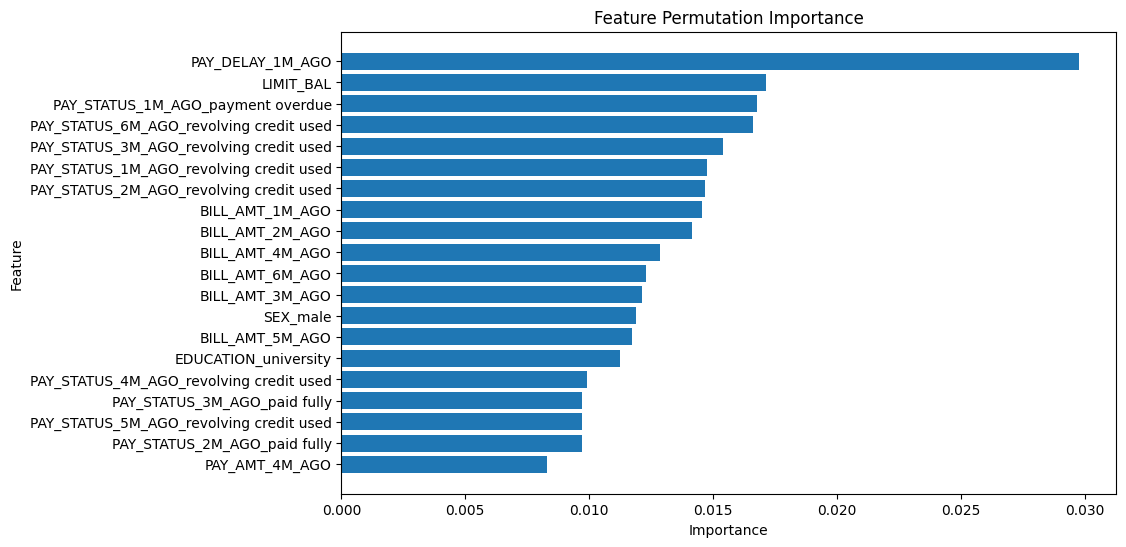

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_payment overdue', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_3M_AGO_paid full

In [ ]:
et_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   782  3866  807   545      49.21   58.93        82.73     77.47     53.64   
1   696  3935  738   631      48.54   52.45        84.21     77.18     50.42   
2   679  3953  720   648      48.53   51.17        84.59     77.20     49.82   
3   628  4045  628   699      50.00   47.32        86.56     77.88     48.63   
4   594  4092  581   733      50.55   44.76        87.57     78.10     47.48   
5   577  4115  558   750      50.84   43.48        88.06     78.20     46.87   
6   413  4298  375   914      52.41   31.12        91.98     78.52     39.05   
7   412  4304  369   915      52.75   31.05        92.10     78.60     39.09   
8   410  4299  374   917      52.30   30.90        92.00     78.48     38.84   
9   411  4307  366   916      52.90   30.97        92.17     78.63     39.07   
10  416  4300  373   911      52.72   31.35        92.02     78.60     39.32   
11  414  4294  379   913      52.21   31.20        91.89     78.47     39.06   
12  420  4293  380   907      52.50   31.65        91.87     78.55     39.49   
13  427  4290  383   900      52.72   32.18        91.80     78.62     39.96   
14  423  4300  373   904      53.14   31.88        92.02     78.72     39.85   
15  358  4421  252   969      58.69   26.98        94.61     79.65     36.96   
16  301  4479  194  1026      60.81   22.68        95.85     79.67     33.04   
17  306  4472  201  1021      60.36   23.06        95.70     79.63     33.37   
18  262  4521  152  1065      63.29   19.74        96.75     79.72     30.10   
19  260  4521  152  1067      63.11   19.59        96.75     79.68     29.90   
20  261  4522  151  1066      63.35   19.67        96.77     79.72     30.02   

    balanced_accuracy  num_feat_missing  \
0               70.83                 0   
1               68.33                 1   
2               67.88                 2   
3               66.94                 3   
4               66.16                 4   
5               65.77                 5   
6               61.55                 6   
7               61.58                 7   
8               61.45                 8   
9               61.57                 9   
10              61.68                10   
11              61.54                11   
12              61.76                12   
13              61.99                13   
14              61.95                14   
15              60.79                15   
16              59.27                16   
17              59.38                17   
18              58.25                18   
19              58.17                19   
20              58.22                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:48:05.045781

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
et_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   782  3866  807  545      49.21   58.93        82.73     77.47     53.64   
1   707  3905  768  620      47.93   53.28        83.57     76.87     50.46   
2   701  3919  754  626      48.18   52.83        83.86     77.00     50.40   
3   691  3883  790  636      46.66   52.07        83.09     76.23     49.22   
4   647  3985  688  680      48.46   48.76        85.28     77.20     48.61   
5   636  3998  675  691      48.51   47.93        85.56     77.23     48.22   
6   519  4185  488  808      51.54   39.11        89.56     78.40     44.47   
7   515  4187  486  812      51.45   38.81        89.60     78.37     44.24   
8   512  4189  484  815      51.41   38.58        89.64     78.35     44.08   
9   517  4191  482  810      51.75   38.96        89.69     78.47     44.45   
10  517  4186  487  810      51.49   38.96        89.58     78.38     44.36   
11  526  4180  493  801      51.62   39.64        89.45     78.43     44.84   
12  524  4180  493  803      51.52   39.49        89.45     78.40     44.71   
13  530  4169  504  797      51.26   39.94        89.21     78.32     44.90   
14  528  4173  500  799      51.36   39.79        89.30     78.35     44.84   
15  478  4268  405  849      54.13   36.02        91.33     79.10     43.26   
16  463  4300  373  864      55.38   34.89        92.02     79.38     42.81   
17  462  4300  373  865      55.33   34.82        92.02     79.37     42.74   
18  393  4383  290  934      57.54   29.62        93.79     79.60     39.10   
19  390  4378  295  937      56.93   29.39        93.69     79.47     38.77   
20  401  4377  296  926      57.53   30.22        93.67     79.63     39.62   

    balanced_accuracy  num_feat_missing  \
0               70.83                 0   
1               68.42                 1   
2               68.35                 2   
3               67.58                 3   
4               67.02                 4   
5               66.74                 5   
6               64.33                 6   
7               64.20                 7   
8               64.11                 8   
9               64.32                 9   
10              64.27                10   
11              64.54                11   
12              64.47                12   
13              64.58                13   
14              64.54                14   
15              63.68                15   
16              63.45                16   
17              63.42                17   
18              61.70                18   
19              61.54                19   
20              61.94                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
et_perf_temp, et_orig_missing_temp, et_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
et_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  782  3866  807   545      49.21   58.93        82.73     77.47     53.64   
1  632  4034  639   695      49.72   47.63        86.33     77.77     48.65   
2  618  4053  620   709      49.92   46.57        86.73     77.85     48.19   
3  588  4105  568   739      50.87   44.31        87.85     78.22     47.36   
4  573  4123  550   754      51.02   43.18        88.23     78.27     46.78   
5  383  4325  348   944      52.39   28.86        92.55     78.47     37.22   
6   17  4662   11  1310      60.71    1.28        99.76     77.98      2.51   

   balanced_accuracy  num_feat_missing  \
0              70.83                 0   
1              66.98                 4   
2              66.65                 5   
3              66.08                 9   
4              65.71                13   
5              60.71                17   
6              50.52                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_temp_mf, et_orig_missing_temp_mf, et_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:54:55.600481

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
et_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  782  3866  807   545      49.21   58.93        82.73     77.47     53.64   
1  668  3935  738   659      47.51   50.34        84.21     76.72     48.88   
2  647  3956  717   680      47.43   48.76        84.66     76.72     48.09   
3  603  4055  618   724      49.39   45.44        86.78     77.63     47.33   
4  601  4073  600   726      50.04   45.29        87.16     77.90     47.55   
5  370  4348  325   957      53.24   27.88        93.05     78.63     36.60   
6  165  4566  107  1162      60.66   12.43        97.71     78.85     20.64   

   balanced_accuracy  num_feat_missing  \
0              70.83                 0   
1              67.27                 4   
2              66.71                 5   
3              66.11                 9   
4              66.23                13   
5              60.46                17   
6              55.07                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, default_cc_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = default_cc_scaler)

In [ ]:
default_cc_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
default_cc_imputation_scaled_values_dict

{'LIMIT_BAL': 0.1313131313131313,
 'AGE': 0.2241379310344827,
 'BILL_AMT_1M_AGO': 0.16610786211021944,
 'BILL_AMT_2M_AGO': 0.08414847207256217,
 'BILL_AMT_3M_AGO': 0.09733066571938552,
 'BILL_AMT_4M_AGO': 0.17797945715184638,
 'BILL_AMT_5M_AGO': 0.0984229131238814,
 'BILL_AMT_6M_AGO': 0.27393724731357977,
 'PAY_AMT_1M_AGO': 0.004158415841584159,
 'PAY_AMT_2M_AGO': 0.0011892470219841485,
 'PAY_AMT_3M_AGO': 0.002008838891120932,
 'PAY_AMT_4M_AGO': 0.0028360909591092403,
 'PAY_AMT_5M_AGO': 0.0035167597044984044,
 'PAY_AMT_6M_AGO': 0.002845527684138839,
 'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_married': 0.0,
 'MARRIAGE_others': 0.0,
 'MARRIAGE_single': 1.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_payment overdue': 0.0,
 'PAY_STATUS_1M_AGO_revolv

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1],
  }
else:
  # best model
  svm_param_grid = {
    'C': [0.1],
    'kernel': ['rbf'],
    'gamma': [0.5]
}

svm_classifier = SVC(class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:56:54.553460

Nested Cross-validation Results:
Individual scores: [0.53832069 0.5270936  0.53481013]
Average nested CV score: 0.533 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.533
2025-01-18 15:58:25.684706

Execution time: 1.52 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:18:46.169761

Nested Cross-validation Results:
Individual scores: [0.53566895 0.5270936  0.5323454 ]
Average nested CV score: 0.532 (+/- 0.007)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.533
2025-01-17 12:44:37.849256

Execution time: 25.86 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1", n_repeats=3)
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue  9.582871e-02  0.002350
31        PAY_STATUS_2M_AGO_payment overdue  6.616633e-03  0.001190
34        PAY_STATUS_3M_AGO_payment overdue  4.414787e-03  0.000377
39             PAY_STATUS_5M_AGO_paid fully  3.960900e-03  0.000530
35  PAY_STATUS_3M_AGO_revolving credit used  3.531509e-03  0.000672
29  PAY_STATUS_1M_AGO_revolving credit used  3.422109e-03  0.001187
20                                 SEX_male  3.247294e-03  0.000314
30             PAY_STATUS_2M_AGO_paid fully  3.099643e-03  0.000177
23                     EDUCATION_university  3.053628e-03  0.000118
38  PAY_STATUS_4M_AGO_revolving credit used  2.873408e-03  0.000397
33             PAY_STATUS_3M_AGO_paid fully  2.812571e-03  0.000438
44  PAY_STATUS_6M_AGO_revolving credit used  2.739863e-03  0.000673
32  PAY_STATUS_2M_AGO_revolving credit used  2.630780e-03  0.000216
21                    EDUCATION_high school  2.423814e-03  0.000363
37        PAY_STATUS_4M_AGO_payment overdue  2.358325e-03  0.000767
42             PAY_STATUS_6M_AGO_paid fully  2.246620e-03  0.000413
41  PAY_STATUS_5M_AGO_revolving credit used  1.954778e-03  0.000444
24                         MARRIAGE_married  1.710420e-03  0.000069
36             PAY_STATUS_4M_AGO_paid fully  1.660137e-03  0.000417
43        PAY_STATUS_6M_AGO_payment overdue  1.580450e-03  0.000057
26                          MARRIAGE_single  1.367741e-03  0.000368
40        PAY_STATUS_5M_AGO_payment overdue  1.012390e-03  0.000233
27             PAY_STATUS_1M_AGO_paid fully  7.144033e-04  0.000263
14                         PAY_DELAY_1M_AGO  6.301114e-04  0.000167
0                                 LIMIT_BAL  5.777212e-04  0.000459
25                          MARRIAGE_others  1.442169e-04  0.000023
17                         PAY_DELAY_4M_AGO  1.199655e-04  0.000303
16                         PAY_DELAY_3M_AGO  3.204005e-06  0.000073
12                           PAY_AMT_5M_AGO -2.851997e-09  0.000040
22                         EDUCATION_others -1.140799e-08  0.000079
2                           BILL_AMT_1M_AGO -4.584528e-06  0.000055
9                            PAY_AMT_2M_AGO -1.615799e-05  0.000023
10                           PAY_AMT_3M_AGO -1.615799e-05  0.000023
18                         PAY_DELAY_5M_AGO -3.594745e-05  0.000052
11                           PAY_AMT_4M_AGO -4.847396e-05  0.000000
8                            PAY_AMT_1M_AGO -4.847396e-05  0.000000
3                           BILL_AMT_2M_AGO -5.305411e-05  0.000093
13                           PAY_AMT_6M_AGO -6.463480e-05  0.000023
15                         PAY_DELAY_2M_AGO -1.002734e-04  0.000216
7                           BILL_AMT_6M_AGO -1.280501e-04  0.000069
1                                       AGE -1.281014e-04  0.000181
4                           BILL_AMT_3M_AGO -1.338397e-04  0.000060
6                           BILL_AMT_5M_AGO -1.442190e-04  0.000100
5                           BILL_AMT_4M_AGO -1.707212e-04  0.000040
19                         PAY_DELAY_6M_AGO -1.957269e-04  0.000222

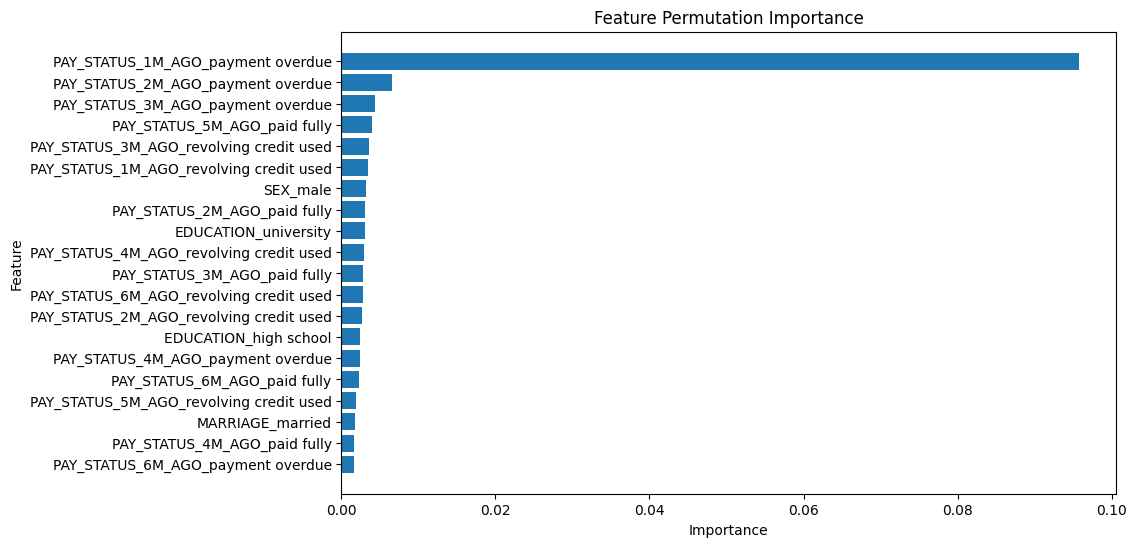

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_5M_AGO_paid fully
Removing related features:  ['PAY_STATUS_5M_AGO_paid ful

In [ ]:
svm_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   736  3921  752   591      49.46   55.46        83.91     77.62     52.29   
1   606  4042  631   721      48.99   45.67        86.50     77.47     47.27   
2   490  4197  476   837      50.72   36.93        89.81     78.12     42.74   
3   433  4284  389   894      52.68   32.63        91.68     78.62     40.30   
4   410  4310  363   917      53.04   30.90        92.23     78.67     39.05   
5   402  4325  348   925      53.60   30.29        92.55     78.78     38.71   
6   378  4338  335   949      53.02   28.49        92.83     78.60     37.06   
7    90  4631   42  1237      68.18    6.78        99.10     78.68     12.34   
8    17  4666    7  1310      70.83    1.28        99.85     78.05      2.52   
9    15  4668    5  1312      75.00    1.13        99.89     78.05      2.23   
10   12  4670    3  1315      80.00    0.90        99.94     78.03      1.79   
11    9  4670    3  1318      75.00    0.68        99.94     77.98      1.34   
12    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
13    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
14    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
15    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
16    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
17    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
18    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.69                 0   
1               66.08                 1   
2               63.37                 2   
3               62.15                 3   
4               61.56                 4   
5               61.42                 5   
6               60.66                 6   
7               52.94                 7   
8               50.57                 8   
9               50.51                 9   
10              50.42                10   
11              50.31                11   
12              49.99                12   
13              49.99                13   
14              49.99                14   
15              49.99                15   
16              49.99                16   
17              49.99                17   
18              49.99                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:11:42.917465

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
svm_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   736  3921   752   591      49.46   55.46        83.91     77.62     52.29   
1   619  3984   689   708      47.32   46.65        85.26     76.72     46.98   
2   644  3612  1061   683      37.77   48.53        77.30     70.93     42.48   
3   404  4337   336   923      54.59   30.44        92.81     79.02     39.09   
4   377  4350   323   950      53.86   28.41        93.09     78.78     37.20   
5   374  4353   320   953      53.89   28.18        93.15     78.78     37.01   
6   369  4357   316   958      53.87   27.81        93.24     78.77     36.68   
7    96  4625    48  1231      66.67    7.23        98.97     78.68     13.05   
8     6  4669     4  1321      60.00    0.45        99.91     77.92      0.90   
9     1  4671     2  1326      33.33    0.08        99.96     77.87      0.15   
10    1  4671     2  1326      33.33    0.08        99.96     77.87      0.15   
11    1  4672     1  1326      50.00    0.08        99.98     77.88      0.15   
12    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
13    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
14    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
15    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
16    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
17    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
18    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.69                 0   
1               65.95                 1   
2               62.91                 2   
3               61.63                 3   
4               60.75                 4   
5               60.67                 5   
6               60.52                 6   
7               53.10                 7   
8               50.18                 8   
9               50.02                 9   
10              50.02                10   
11              50.03                11   
12              49.99                12   
13              49.99                13   
14              49.99                14   
15              49.99                15   
16              49.99                16   
17              49.99                17   
18              49.99                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm_perf_temp, svm_orig_missing_temp, svm_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
svm_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   736  3921   752  591      49.46   55.46        83.91     77.62     52.29   
1  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
2  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
3  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
4  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
5  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
6  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
7  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              69.69                 0   
1              50.00                 4   
2              50.00                 8   
3              50.00                12   
4              50.00                16   
5              50.00                17   
6              50.00                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_temp_mf, svm_orig_missing_temp_mf, svm_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:21:28.640739

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
svm_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  736  3921   752   591      49.46   55.46        83.91     77.62     52.29   
1  619  3984   689   708      47.32   46.65        85.26     76.72     46.98   
2  638  3615  1058   689      37.62   48.08        77.36     70.88     42.21   
3  395  4342   331   932      54.41   29.77        92.92     78.95     38.48   
4  362  4359   314   965      53.55   27.28        93.28     78.68     36.15   
5  359  4358   315   968      53.26   27.05        93.26     78.62     35.88   
6  359  4367   306   968      53.98   27.05        93.45     78.77     36.04   
7   10  4671     2  1317      83.33    0.75        99.96     78.02      1.49   

   balanced_accuracy  num_feat_missing  \
0              69.69                 0   
1              65.95                 4   
2              62.72                 8   
3              61.34                12   
4              60.28                16   
5              60.16                17   
6              60.25                18   
7              50.36                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_default_cc_dist_corr = default_cc_dist_corr[present_features]
filtered_default_cc_dist_corr = filtered_default_cc_dist_corr[filtered_default_cc_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
eliminated feature:  PAY_STATUS_1M_AGO_payment overdue 0.9603174252876002
appended feature:  PAY_DELAY_2M_AGO
eliminated feature:  PAY_STATUS_2M_AGO_payment overdue 0.9975801550270001
appended feature:  PAY_DELAY_3M_AGO
eliminated feature:  PAY_STATUS_3M_AGO_payment overdue 0.9984917697361416
appended feature:  PAY_DELAY_4M_AGO
eliminated feature:  PAY_STATUS_4M_AGO_payment overdue 0.998029305232507
appended feature:  PAY_DELAY_5M_AGO
eliminated feature:  PAY_STATUS_5M_AGO_payment overdue 0.997728264791085
appended feature:  PAY_DELAY_6M_AGO
eliminated feature:  PAY_STATUS_6M_AGO_payment overdue 0.9981510390668386
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
eliminated feature:  PAY_STATUS_2M_AGO_revolving credit used 0.8714268865267695
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended feat

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  33


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [2.0],
      'penalty': ['l2'],
      'solver': ['saga']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:09:24.389803

Nested Cross-validation Results:
Individual scores: [0.53275993 0.53713389 0.52996685]
Average nested CV score: 0.533 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-18 15:09:28.451258

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:44:38.151924

Nested Cross-validation Results:
Individual scores: [0.53165829 0.53605016 0.52956167]
Average nested CV score: 0.532 (+/- 0.005)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-17 12:45:03.660655

Execution time: 0.43 minutes
```

In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.107946  0.003127
7                                 LIMIT_BAL    0.020677  0.003140
2                          PAY_DELAY_3M_AGO    0.013754  0.002241
30                          BILL_AMT_1M_AGO    0.008350  0.000443
23             PAY_STATUS_1M_AGO_paid fully    0.007513  0.001443
19             PAY_STATUS_2M_AGO_paid fully    0.007392  0.000759
6   PAY_STATUS_1M_AGO_revolving credit used    0.007096  0.001123
4                          PAY_DELAY_5M_AGO    0.005482  0.000811
17  PAY_STATUS_6M_AGO_revolving credit used    0.004142  0.001530
3                          PAY_DELAY_4M_AGO    0.003708  0.000620
16  PAY_STATUS_5M_AGO_revolving credit used    0.003312  0.000715
25                                 SEX_male    0.003237  0.000542
20             PAY_STATUS_4M_AGO_paid fully    0.003034  0.000436
10  PAY_STATUS_3M_AGO_revolving credit used    0.001990  0.001219
22             PAY_STATUS_6M_AGO_paid fully    0.001689  0.000564
24                         EDUCATION_others    0.001419  0.000454
26                     EDUCATION_university    0.001183  0.000302
27                          MARRIAGE_single    0.001128  0.001366
5                          PAY_DELAY_6M_AGO    0.000683  0.000152
8                            PAY_AMT_1M_AGO    0.000602  0.000326
32                          MARRIAGE_others    0.000576  0.000237
29                                      AGE    0.000384  0.000647
15                           PAY_AMT_6M_AGO    0.000158  0.000346
28                    EDUCATION_high school    0.000135  0.000194
31                          BILL_AMT_6M_AGO   -0.000014  0.000437
11                           PAY_AMT_3M_AGO   -0.000105  0.000539
18             PAY_STATUS_3M_AGO_paid fully   -0.000106  0.000181
14  PAY_STATUS_4M_AGO_revolving credit used   -0.000122  0.000880
9                            PAY_AMT_2M_AGO   -0.000190  0.000153
12                           PAY_AMT_4M_AGO   -0.000197  0.000450
13                           PAY_AMT_5M_AGO   -0.000234  0.000405
1                          PAY_DELAY_2M_AGO   -0.000324  0.000460
21             PAY_STATUS_5M_AGO_paid fully   -0.000333  0.000176

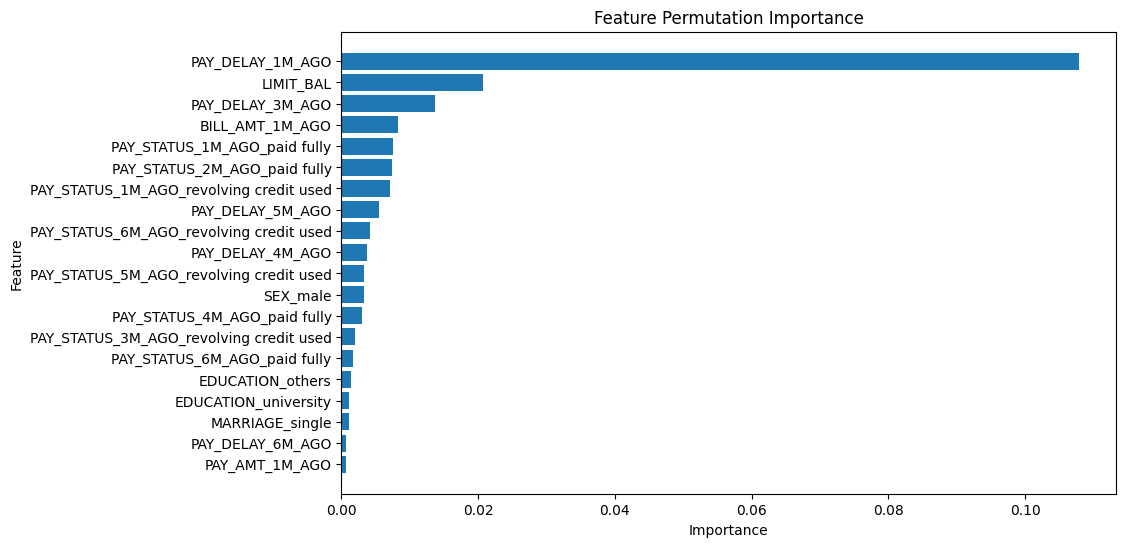

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_paid fully
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully']
Original feat removed so far:  ['P

In [ ]:
lr_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1   485  4169  504   842      49.04   36.55        89.21     77.57     41.88   
2   442  4214  459   885      49.06   33.31        90.18     77.60     39.68   
3   334  4351  322   993      50.91   25.17        93.11     78.08     33.69   
4   302  4365  308  1025      49.51   22.76        93.41     77.78     31.18   
5   307  4377  296  1020      50.91   23.13        93.67     78.07     31.81   
6   310  4355  318  1017      49.36   23.36        93.19     77.75     31.71   
7   215  4432  241  1112      47.15   16.20        94.84     77.45     24.12   
8    16  4660   13  1311      55.17    1.21        99.72     77.93      2.36   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               62.88                 1   
2               61.74                 2   
3               59.14                 3   
4               58.08                 4   
5               58.40                 5   
6               58.28                 6   
7               55.52                 7   
8               50.46                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_X_train.columns

Index(['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO',
       'PAY_STATUS_1M_AGO_revolving credit used', 'LIMIT_BAL',
       'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO',
       'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_AMT_6M_AGO',
       'PAY_STATUS_5M_AGO_revolving credit used',
       'PAY_STATUS_6M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully',
       'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully',
       'EDUCATION_others', 'SEX_male', 'EDUCATION_university',
       'MARRIAGE_single', 'EDUCATION_high school', 'AGE', 'BILL_AMT_1M_AGO',
       'BILL_AMT_6M_AGO', 'MARRIAGE_others'],
      dtype='object')

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_default_cc_cat_vars = [col for col in lr_X_train.columns if col in default_cc_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:24:31.124560

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811  577      48.05   56.52        82.64     76.87     51.94   
1   699  3804  869  628      44.58   52.68        81.40     75.05     48.29   
2   676  3884  789  651      46.14   50.94        83.12     76.00     48.42   
3   663  3892  781  664      45.91   49.96        83.29     75.92     47.85   
4   628  3974  699  699      47.32   47.32        85.04     76.70     47.32   
5   598  4012  661  729      47.50   45.06        85.85     76.83     46.25   
6   587  4046  627  740      48.35   44.24        86.58     77.22     46.20   
7   586  4050  623  741      48.47   44.16        86.67     77.27     46.21   
8   583  4081  592  744      49.62   43.93        87.33     77.73     46.60   
9   547  4112  561  780      49.37   41.22        87.99     77.65     44.93   
10  495  4250  423  832      53.92   37.30        90.95     79.08     44.10   
11  472  4292  381  855      55.33   35.57        91.85     79.40     43.30   
12  456  4311  362  871      55.75   34.36        92.25     79.45     42.52   
13  441  4342  331  886      57.12   33.23        92.92     79.72     42.02   
14  446  4337  336  881      57.03   33.61        92.81     79.72     42.29   
15  458  4312  361  869      55.92   34.51        92.27     79.50     42.68   
16  457  4322  351  870      56.56   34.44        92.49     79.65     42.81   
17  466  4300  373  861      55.54   35.12        92.02     79.43     43.03   
18  466  4299  374  861      55.48   35.12        92.00     79.42     43.01   
19  468  4299  374  859      55.58   35.27        92.00     79.45     43.15   
20  465  4301  372  862      55.56   35.04        92.04     79.43     42.98   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               67.04                 1   
2               67.03                 2   
3               66.62                 3   
4               66.18                 4   
5               65.46                 5   
6               65.41                 6   
7               65.41                 7   
8               65.63                 8   
9               64.61                 9   
10              64.13                10   
11              63.71                11   
12              63.31                12   
13              63.07                13   
14              63.21                14   
15              63.39                15   
16              63.46                16   
17              63.57                17   
18              63.56                18   
19              63.63                19   
20              63.54                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_perf_temp, lr_orig_missing_temp, lr_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862   811   577      48.05   56.52        82.64     76.87     51.94   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_temp_mf, lr_orig_missing_temp_mf, lr_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:29:04.134391

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1  619  3925  748   708      45.28   46.65        83.99     75.73     45.95   
2  639  3891  782   688      44.97   48.15        83.27     75.50     46.51   
3  576  4105  568   751      50.35   43.41        87.85     78.02     46.62   
4  355  4392  281   972      55.82   26.75        93.99     79.12     36.17   
5  354  4373  300   973      54.13   26.68        93.58     78.78     35.74   
6  170  4544  129  1157      56.86   12.81        97.24     78.57     20.91   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              65.32                 4   
2              65.71                 5   
3              65.63                 8   
4              60.37                11   
5              60.13                14   
6              55.03                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [None],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.01]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:30:39.222702

Nested Cross-validation Results:
Individual scores: [0.70310277 0.70311279 0.69981183]
Average nested CV score: 0.702 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.702
2025-01-18 16:30:43.148132

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:45:03.669593

Nested Cross-validation Results:
Individual scores: [0.69644828 0.70314135 0.69412266]
Average nested CV score: 0.698 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.702
2025-01-17 12:45:50.569501

Execution time: 0.78 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28  PAY_STATUS_1M_AGO_payment overdue    0.085718  0.001662
37  PAY_STATUS_4M_AGO_payment overdue    0.024262  0.001571
36       PAY_STATUS_4M_AGO_paid fully    0.010800  0.001018
34  PAY_STATUS_3M_AGO_payment overdue    0.009667  0.001198
9                      PAY_AMT_2M_AGO    0.006207  0.001269
33       PAY_STATUS_3M_AGO_paid fully    0.004582  0.000830
2                     BILL_AMT_1M_AGO    0.004367  0.000902
0                           LIMIT_BAL    0.003489  0.000990
14                   PAY_DELAY_1M_AGO    0.003310  0.000596
11                     PAY_AMT_4M_AGO    0.002691  0.000751

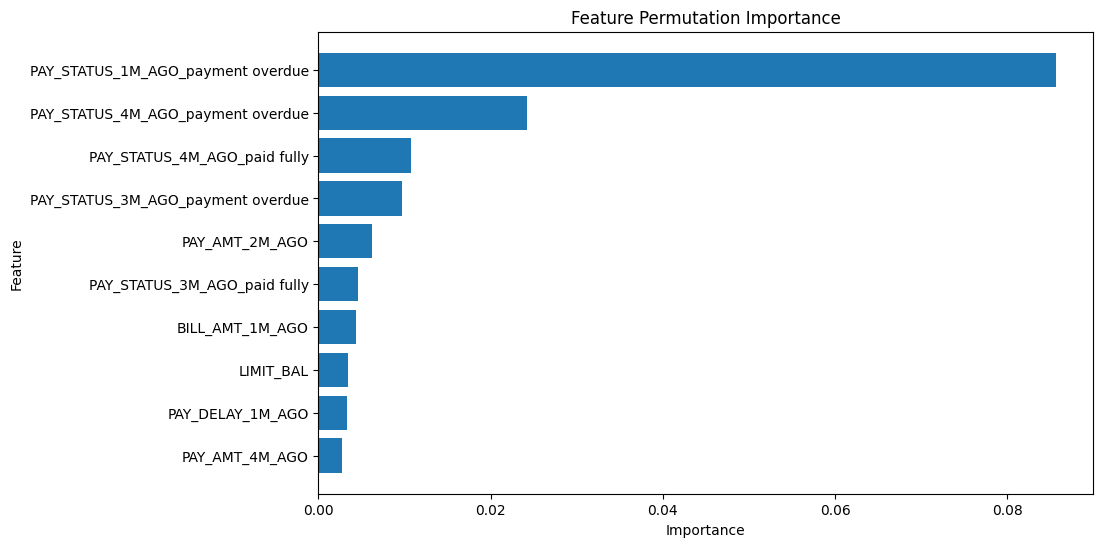

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment overdue', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_

In [ ]:
dt2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1   587  3833   840   740      41.14   44.24        82.02     73.67     42.63   
2   377  4056   617   950      37.93   28.41        86.80     73.88     32.49   
3   160  4429   244  1167      39.60   12.06        94.78     76.48     18.49   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.56                 0   
1               63.13                 1   
2               57.60                 2   
3               53.42                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:30:45.276496

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
dt2_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1   602  3769   904   725      39.97   45.37        80.65     72.85     42.50   
2   496  3892   781   831      38.84   37.38        83.29     73.13     38.10   
3   186  4391   282  1141      39.74   14.02        93.97     76.28     20.72   
4   152  4488   185  1175      45.10   11.45        96.04     77.33     18.27   
5   171  4461   212  1156      44.65   12.89        95.46     77.20     20.00   
6    80  4597    76  1247      51.28    6.03        98.37     77.95     10.79   
7    56  4601    72  1271      43.75    4.22        98.46     77.62      7.70   
8    50  4613    60  1277      45.45    3.77        98.72     77.72      6.96   
9    62  4605    68  1265      47.69    4.67        98.54     77.78      8.51   
10   20  4652    21  1307      48.78    1.51        99.55     77.87      2.92   
11   20  4652    21  1307      48.78    1.51        99.55     77.87      2.92   
12   20  4652    21  1307      48.78    1.51        99.55     77.87      2.92   
13   20  4652    21  1307      48.78    1.51        99.55     77.87      2.92   
14   20  4652    21  1307      48.78    1.51        99.55     77.87      2.92   
15   10  4663    10  1317      50.00    0.75        99.79     77.88      1.48   
16    9  4665     8  1318      52.94    0.68        99.83     77.90      1.34   
17   10  4664     9  1317      52.63    0.75        99.81     77.90      1.49   
18   12  4663    10  1315      54.55    0.90        99.79     77.92      1.78   
19   19  4654    19  1308      50.00    1.43        99.59     77.88      2.78   
20   16  4654    19  1311      45.71    1.21        99.59     77.83      2.35   

    balanced_accuracy  num_feat_missing  \
0               69.56                 0   
1               63.01                 1   
2               60.33                 2   
3               53.99                 3   
4               53.75                 4   
5               54.17                 5   
6               52.20                 6   
7               51.34                 7   
8               51.24                 8   
9               51.61                 9   
10              50.53                10   
11              50.53                11   
12              50.53                12   
13              50.53                13   
14              50.53                14   
15              50.27                15   
16              50.25                16   
17              50.28                17   
18              50.35                18   
19              50.51                19   
20              50.40                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
dt2_perf_temp, dt2_orig_missing_temp, dt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
dt2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1  555  3955   718   772      43.60   41.82        84.64     75.17     42.69   
2  350  4157   516   977      40.42   26.38        88.96     75.12     31.92   
3  193  4361   312  1134      38.22   14.54        93.32     75.90     21.07   
4    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.56                 0   
1              63.23                 4   
2              57.67                 8   
3              53.93                12   
4              50.00                16   
5              50.00                17   
6              50.00                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_temp_mf, dt2_orig_missing_temp_mf, dt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:37:36.249206

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
dt2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1  572  3884   789   755      42.03   43.10        83.12     74.27     42.56   
2  466  4006   667   861      41.13   35.12        85.73     74.53     37.89   
3  203  4354   319  1124      38.89   15.30        93.17     75.95     21.96   
4    1  4673     0  1326     100.00    0.08       100.00     77.90      0.15   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.56                 0   
1              63.11                 4   
2              60.42                 8   
3              54.24                12   
4              50.04                16   
5              50.00                17   
6              50.00                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [1],
    'max_depth': [None],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:39:55.125792

Nested Cross-validation Results:
Individual scores: [0.72185009 0.71248198 0.71944119]
Average nested CV score: 0.718 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.718
2025-01-18 16:40:21.447508

Execution time: 0.44 minutes


```
Starting hyperparameter tuning at: 2025-01-18 04:25:39.175566

Nested Cross-validation Results:
Individual scores: [0.71803422 0.71088636 0.71687932]
Average nested CV score: 0.715 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.718
2025-01-18 06:08:48.098420

Execution time: 103.15 minutes

```

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.014033  0.001450
2                           BILL_AMT_1M_AGO    0.013021  0.000519
10                           PAY_AMT_3M_AGO    0.011795  0.000986
11                           PAY_AMT_4M_AGO    0.011794  0.001044
7                           BILL_AMT_6M_AGO    0.011558  0.001001
8                            PAY_AMT_1M_AGO    0.011214  0.001121
6                           BILL_AMT_5M_AGO    0.008943  0.000274
9                            PAY_AMT_2M_AGO    0.008097  0.000886
5                           BILL_AMT_4M_AGO    0.007887  0.000551
13                           PAY_AMT_6M_AGO    0.007754  0.000805
0                                 LIMIT_BAL    0.006874  0.000558
12                           PAY_AMT_5M_AGO    0.005406  0.000621
3                           BILL_AMT_2M_AGO    0.004318  0.000252
4                           BILL_AMT_3M_AGO    0.003996  0.000634
1                                       AGE    0.002884  0.000399
16                         PAY_DELAY_3M_AGO    0.002572  0.000587
29  PAY_STATUS_1M_AGO_revolving credit used    0.002141  0.000527
34        PAY_STATUS_3M_AGO_payment overdue    0.001537  0.000604
44  PAY_STATUS_6M_AGO_revolving credit used    0.001490  0.000229
42             PAY_STATUS_6M_AGO_paid fully    0.001485  0.000351
27             PAY_STATUS_1M_AGO_paid fully    0.001439  0.000270
41  PAY_STATUS_5M_AGO_revolving credit used    0.001279  0.000213
20                                 SEX_male    0.001090  0.000135
33             PAY_STATUS_3M_AGO_paid fully    0.001058  0.000374
17                         PAY_DELAY_4M_AGO    0.000979  0.000534
23                     EDUCATION_university    0.000920  0.000220
37        PAY_STATUS_4M_AGO_payment overdue    0.000899  0.000541
22                         EDUCATION_others    0.000828  0.000418
36             PAY_STATUS_4M_AGO_paid fully    0.000813  0.000280
18                         PAY_DELAY_5M_AGO    0.000774  0.000180
32  PAY_STATUS_2M_AGO_revolving credit used    0.000761  0.000565
38  PAY_STATUS_4M_AGO_revolving credit used    0.000752  0.000405
26                          MARRIAGE_single    0.000721  0.000128
39             PAY_STATUS_5M_AGO_paid fully    0.000697  0.000261
30             PAY_STATUS_2M_AGO_paid fully    0.000656  0.000153
40        PAY_STATUS_5M_AGO_payment overdue    0.000643  0.000188
19                         PAY_DELAY_6M_AGO    0.000483  0.000179
43        PAY_STATUS_6M_AGO_payment overdue    0.000459  0.000284
35  PAY_STATUS_3M_AGO_revolving credit used    0.000362  0.000291
21                    EDUCATION_high school    0.000347  0.000031
24                         MARRIAGE_married    0.000296  0.000104
25                          MARRIAGE_others    0.000027  0.000000
15                         PAY_DELAY_2M_AGO   -0.000160  0.000726
31        PAY_STATUS_2M_AGO_payment overdue   -0.000174  0.000974
28        PAY_STATUS_1M_AGO_payment overdue   -0.000662  0.000916

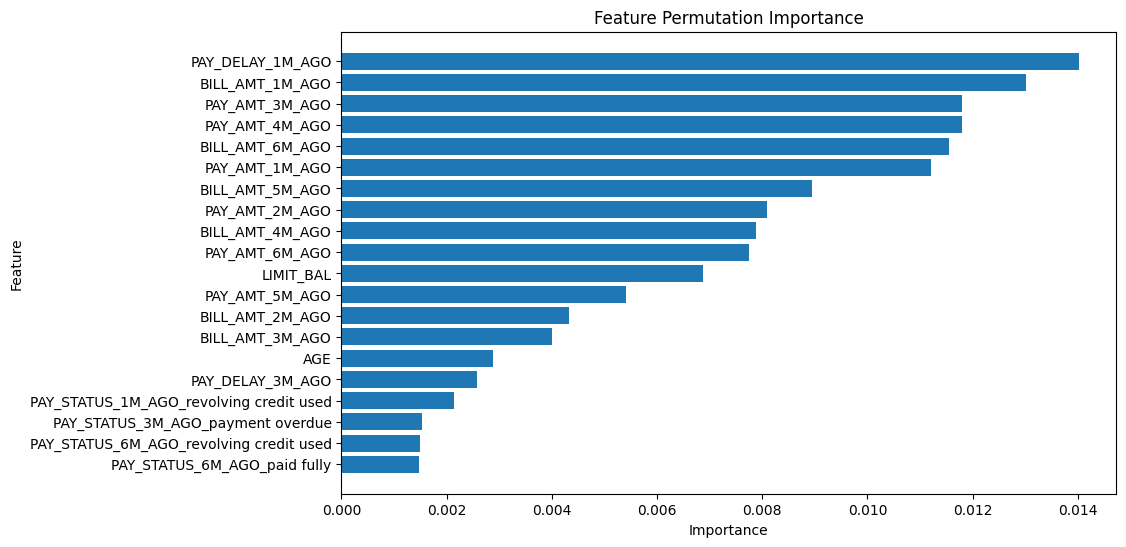

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_6M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_6M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Origina

In [ ]:
rf2_perf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   789  3870  803  538      49.56   59.46        82.82     77.65     54.06   
1   740  3915  758  587      49.40   55.76        83.78     77.58     52.39   
2   651  4070  603  676      51.91   49.06        87.10     78.68     50.45   
3   632  4103  570  695      52.58   47.63        87.80     78.92     49.98   
4   616  4130  543  711      53.15   46.42        88.38     79.10     49.56   
5   615  4130  543  712      53.11   46.35        88.38     79.08     49.50   
6   611  4138  535  716      53.32   46.04        88.55     79.15     49.41   
7   611  4133  540  716      53.08   46.04        88.44     79.07     49.31   
8   606  4138  535  721      53.11   45.67        88.55     79.07     49.11   
9   614  4141  532  713      53.58   46.27        88.62     79.25     49.66   
10  611  4142  531  716      53.50   46.04        88.64     79.22     49.49   
11  582  4170  503  745      53.64   43.86        89.24     79.20     48.26   
12  584  4170  503  743      53.73   44.01        89.24     79.23     48.38   
13  575  4184  489  752      54.04   43.33        89.54     79.32     48.10   
14  564  4190  483  763      53.87   42.50        89.66     79.23     47.51   
15  565  4191  482  762      53.96   42.58        89.69     79.27     47.60   
16  555  4209  464  772      54.47   41.82        90.07     79.40     47.31   
17  490  4266  407  837      54.63   36.93        91.29     79.27     44.06   
18  445  4315  358  882      55.42   33.53        92.34     79.33     41.78   
19  433  4331  342  894      55.87   32.63        92.68     79.40     41.20   
20  444  4313  360  883      55.22   33.46        92.30     79.28     41.67   

    balanced_accuracy  num_feat_missing  \
0               71.14                 0   
1               69.77                 1   
2               68.08                 2   
3               67.71                 3   
4               67.40                 4   
5               67.36                 5   
6               67.30                 6   
7               67.24                 7   
8               67.11                 8   
9               67.44                 9   
10              67.34                10   
11              66.55                11   
12              66.62                12   
13              66.43                13   
14              66.08                14   
15              66.13                15   
16              65.95                16   
17              64.11                17   
18              62.94                18   
19              62.66                19   
20              62.88                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:40:45.376910

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
rf2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   789  3870  803  538      49.56   59.46        82.82     77.65     54.06   
1   751  3891  782  576      48.99   56.59        83.27     77.37     52.52   
2   716  3972  701  611      50.53   53.96        85.00     78.13     52.19   
3   704  4010  663  623      51.50   53.05        85.81     78.57     52.26   
4   674  4063  610  653      52.49   50.79        86.95     78.95     51.63   
5   656  4080  593  671      52.52   49.43        87.31     78.93     50.93   
6   649  4083  590  678      52.38   48.91        87.37     78.87     50.58   
7   628  4112  561  699      52.82   47.32        87.99     79.00     49.92   
8   615  4128  545  712      53.02   46.35        88.34     79.05     49.46   
9   615  4121  552  712      52.70   46.35        88.19     78.93     49.32   
10  611  4135  538  716      53.18   46.04        88.49     79.10     49.35   
11  610  4125  548  717      52.68   45.97        88.27     78.92     49.09   
12  607  4142  531  720      53.34   45.74        88.64     79.15     49.25   
13  580  4161  512  747      53.11   43.71        89.04     79.02     47.95   
14  627  4090  583  700      51.82   47.25        87.52     78.62     49.43   
15  615  4056  617  712      49.92   46.35        86.80     77.85     48.07   
16  601  4098  575  726      51.11   45.29        87.70     78.32     48.02   
17  595  4093  580  732      50.64   44.84        87.59     78.13     47.56   
18  594  4093  580  733      50.60   44.76        87.59     78.12     47.50   
19  580  4111  562  747      50.79   43.71        87.97     78.18     46.98   
20  577  4116  557  750      50.88   43.48        88.08     78.22     46.89   

    balanced_accuracy  num_feat_missing  \
0               71.14                 0   
1               69.93                 1   
2               69.48                 2   
3               69.43                 3   
4               68.87                 4   
5               68.37                 5   
6               68.14                 6   
7               67.66                 7   
8               67.34                 8   
9               67.27                 9   
10              67.27                10   
11              67.12                11   
12              67.19                12   
13              66.38                13   
14              67.39                14   
15              66.57                15   
16              66.49                16   
17              66.21                17   
18              66.18                18   
19              65.84                19   
20              65.78                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
rf2_perf_temp, rf2_orig_missing_temp, rf2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
rf2_perf_temp

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  789  3870  803  538      49.56   59.46        82.82     77.65     54.06   
1  568  4128  545  759      51.03   42.80        88.34     78.27     46.56   
2  525  4210  463  802      53.14   39.56        90.09     78.92     45.36   
3  471  4305  368  856      56.14   35.49        92.12     79.60     43.49   
4  435  4328  345  892      55.77   32.78        92.62     79.38     41.29   
5  399  4358  315  928      55.88   30.07        93.26     79.28     39.10   

   balanced_accuracy  num_feat_missing  \
0              71.14                 0   
1              65.57                 4   
2              64.83                 8   
3              63.81                12   
4              62.70                16   
5              61.66                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_temp_mf, rf2_orig_missing_temp_mf, rf2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:47:19.483910

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
rf2_perf_temp_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  789  3870  803  538      49.56   59.46        82.82     77.65     54.06   
1  622  4034  639  705      49.33   46.87        86.33     77.60     48.07   
2  580  4137  536  747      51.97   43.71        88.53     78.62     47.48   
3  519  4217  456  808      53.23   39.11        90.24     78.93     45.09   
4  491  4262  411  836      54.43   37.00        91.20     79.22     44.06   
5  457  4314  359  870      56.00   34.44        92.32     79.52     42.65   

   balanced_accuracy  num_feat_missing  \
0              71.14                 0   
1              66.60                 4   
2              66.12                 8   
3              64.68                12   
4              64.10                16   
5              63.38                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [100],
      'min_split_gain': [0.5],
      'reg_lambda': [0.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy',
    X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:48:59.841279

Nested Cross-validation Results:
Individual scores: [0.7186461  0.71709062 0.71989281]
Average nested CV score: 0.719 (+/- 0.002)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.719
2025-01-18 16:49:04.755608

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:45:50.584551

Nested Cross-validation Results:
Individual scores: [0.71247698 0.71426894 0.71659276]
Average nested CV score: 0.714 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.719
2025-01-17 12:57:38.241614

Execution time: 11.79 minutes
```

In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.066376  0.000619
0                                 LIMIT_BAL    0.011724  0.001072
2                           BILL_AMT_1M_AGO    0.009792  0.001226
10                           PAY_AMT_3M_AGO    0.006487  0.000605
11                           PAY_AMT_4M_AGO    0.006419  0.001103
16                         PAY_DELAY_3M_AGO    0.005028  0.000917
9                            PAY_AMT_2M_AGO    0.004846  0.000530
8                            PAY_AMT_1M_AGO    0.003773  0.000959
27             PAY_STATUS_1M_AGO_paid fully    0.003708  0.000417
15                         PAY_DELAY_2M_AGO    0.003434  0.001107
4                           BILL_AMT_3M_AGO    0.003374  0.000914
3                           BILL_AMT_2M_AGO    0.002758  0.000410
13                           PAY_AMT_6M_AGO    0.002506  0.000766
22                         EDUCATION_others    0.001952  0.000406
17                         PAY_DELAY_4M_AGO    0.001837  0.000389
19                         PAY_DELAY_6M_AGO    0.001803  0.000733
12                           PAY_AMT_5M_AGO    0.001657  0.000522
26                          MARRIAGE_single    0.001478  0.000730
7                           BILL_AMT_6M_AGO    0.001341  0.000799
20                                 SEX_male    0.001291  0.000625
5                           BILL_AMT_4M_AGO    0.000896  0.000494
1                                       AGE    0.000766  0.000366
36             PAY_STATUS_4M_AGO_paid fully    0.000598  0.000437
18                         PAY_DELAY_5M_AGO    0.000518  0.000543
6                           BILL_AMT_5M_AGO    0.000447  0.000386
23                     EDUCATION_university    0.000264  0.000146
39             PAY_STATUS_5M_AGO_paid fully    0.000063  0.000131
33             PAY_STATUS_3M_AGO_paid fully    0.000016  0.000027
24                         MARRIAGE_married    0.000012  0.000236
44  PAY_STATUS_6M_AGO_revolving credit used   -0.000062  0.000054
42             PAY_STATUS_6M_AGO_paid fully   -0.000094  0.000063
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000368  0.000357

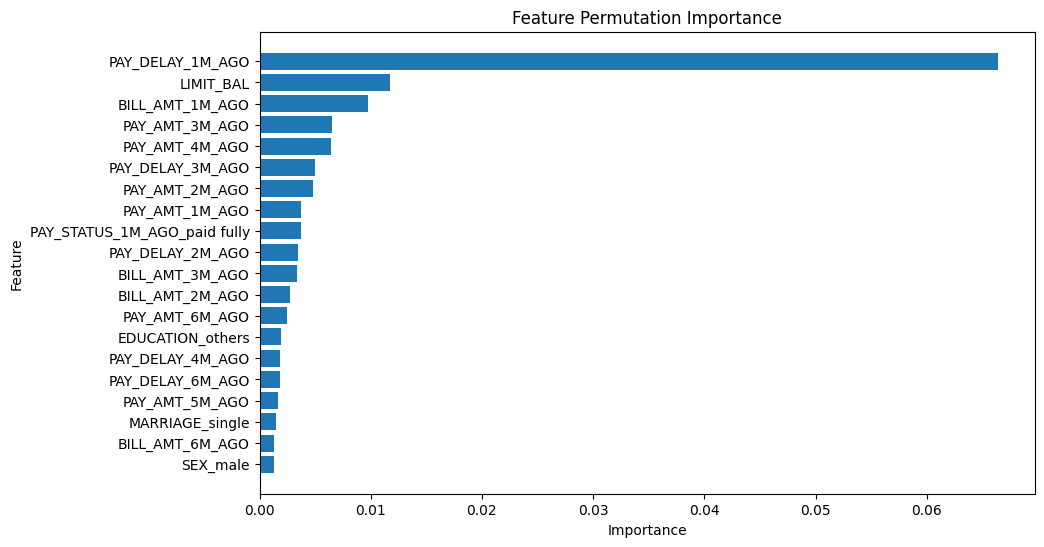

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_D

In [ ]:
gbt2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3737  936   505      46.76   61.94        79.97     75.98     53.29   
1   629  3921  752   698      45.55   47.40        83.91     75.83     46.45   
2   611  3979  694   716      46.82   46.04        85.15     76.50     46.43   
3   479  4258  415   848      53.58   36.10        91.12     78.95     43.13   
4   439  4303  370   888      54.26   33.08        92.08     79.03     41.10   
5   407  4351  322   920      55.83   30.67        93.11     79.30     39.59   
6   314  4462  211  1013      59.81   23.66        95.48     79.60     33.91   
7   289  4488  185  1038      60.97   21.78        96.04     79.62     32.09   
8   298  4474  199  1029      59.96   22.46        95.74     79.53     32.68   
9   298  4486  187  1029      61.44   22.46        96.00     79.73     32.89   
10  244  4514  159  1083      60.55   18.39        96.60     79.30     28.21   
11  223  4536  137  1104      61.94   16.80        97.07     79.32     26.44   
12  222  4535  138  1105      61.67   16.73        97.05     79.28     26.32   
13  221  4534  139  1106      61.39   16.65        97.03     79.25     26.20   
14  211  4544  129  1116      62.06   15.90        97.24     79.25     25.31   
15   19  4662   11  1308      63.33    1.43        99.76     78.02      2.80   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.96                 0   
1               65.65                 1   
2               65.60                 2   
3               63.61                 3   
4               62.58                 4   
5               61.89                 5   
6               59.57                 6   
7               58.91                 7   
8               59.10                 8   
9               59.23                 9   
10              57.49                10   
11              56.94                11   
12              56.89                12   
13              56.84                13   
14              56.57                14   
15              50.60                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:49:10.236719

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
gbt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    822  3737   936  505      46.76   61.94        79.97     75.98     53.29   
1   1013  2549  2124  314      32.29   76.34        54.55     59.37     45.39   
2    959  2772  1901  368      33.53   72.27        59.32     62.18     45.81   
3    914  2950  1723  413      34.66   68.88        63.13     64.40     46.12   
4    880  3075  1598  447      35.51   66.31        65.80     65.92     46.25   
5    806  3270  1403  521      36.49   60.74        69.98     67.93     45.59   
6    789  3327  1346  538      36.96   59.46        71.20     68.60     45.58   
7    775  3404  1269  552      37.92   58.40        72.84     69.65     45.98   
8    756  3411  1262  571      37.46   56.97        72.99     69.45     45.20   
9    889  2720  1953  438      31.28   66.99        58.21     60.15     42.65   
10   827  2788  1885  500      30.49   62.32        59.66     60.25     40.95   
11   790  2883  1790  537      30.62   59.53        61.69     61.22     40.44   
12   695  3270  1403  632      33.13   52.37        69.98     66.08     40.58   
13   653  3367  1306  674      33.33   49.21        72.05     67.00     39.74   
14   650  3355  1318  677      33.03   48.98        71.80     66.75     39.45   
15   773  2786  1887  554      29.06   58.25        59.62     59.32     38.78   
16   971  1963  2710  356      26.38   73.17        42.01     48.90     38.78   
17   937  1869  2804  390      25.05   70.61        40.00     46.77     36.98   
18   849  2208  2465  478      25.62   63.98        47.25     50.95     36.59   
19   963  1718  2955  364      24.58   72.57        36.76     44.68     36.72   
20   939  1725  2948  388      24.16   70.76        36.91     44.40     36.02   

    balanced_accuracy  num_feat_missing  \
0               70.96                 0   
1               65.44                 1   
2               65.79                 2   
3               66.00                 3   
4               66.06                 4   
5               65.36                 5   
6               65.33                 6   
7               65.62                 7   
8               64.98                 8   
9               62.60                 9   
10              60.99                10   
11              60.61                11   
12              61.18                12   
13              60.63                13   
14              60.39                14   
15              58.94                15   
16              57.59                16   
17              55.30                17   
18              55.61                18   
19              54.67                19   
20              53.84                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
gbt2_perf_temp, gbt2_orig_missing_temp, gbt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
gbt2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  822  3737  936   505      46.76   61.94        79.97     75.98     53.29   
1  475  4243  430   852      52.49   35.80        90.80     78.63     42.56   
2  457  4290  383   870      54.40   34.44        91.80     79.12     42.18   
3  328  4459  214   999      60.52   24.72        95.42     79.78     35.10   
4  221  4560  113  1106      66.17   16.65        97.58     79.68     26.61   
5   16  4662   11  1311      59.26    1.21        99.76     77.97      2.36   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.96                 0   
1              63.30                 4   
2              63.12                 5   
3              60.07                 9   
4              57.12                13   
5              50.49                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_temp_mf, gbt2_orig_missing_temp_mf, gbt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:55:49.791357

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
gbt2_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3737   936  505      46.76   61.94        79.97     75.98     53.29   
1  1028  2233  2440  299      29.64   77.47        47.79     54.35     42.88   
2  1017  2328  2345  310      30.25   76.64        49.82     55.75     43.38   
3   959  2540  2133  368      31.02   72.27        54.35     58.32     43.40   
4  1099  1832  2841  228      27.89   82.82        39.20     48.85     41.73   
5   947  2153  2520  380      27.31   71.36        46.07     51.67     39.51   
6  1135  1079  3594  192      24.00   85.53        23.09     36.90     37.48   

   balanced_accuracy  num_feat_missing  \
0              70.96                 0   
1              62.63                 4   
2              63.23                 5   
3              63.31                 9   
4              61.01                13   
5              58.72                17   
6              54.31                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'reg_lambda':[10.0],
    'gamma': [0.1],
    'colsample_bytree':[0.25]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:57:49.024073

Nested Cross-validation Results:
Individual scores: [0.71176553 0.71609852 0.7156392 ]
Average nested CV score: 0.715 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.715
2025-01-18 16:57:53.177265

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:57:38.250353

Nested Cross-validation Results:
Individual scores: [0.70949003 0.71074081 0.70987068]
Average nested CV score: 0.710 (+/- 0.001)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.715
2025-01-17 13:21:50.318554

Execution time: 24.20 minutes
```

In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.040359  0.002026
2                           BILL_AMT_1M_AGO    0.012026  0.000695
0                                 LIMIT_BAL    0.011417  0.000861
6                           BILL_AMT_5M_AGO    0.006990  0.000925
7                           BILL_AMT_6M_AGO    0.006951  0.000860
10                           PAY_AMT_3M_AGO    0.006657  0.001176
9                            PAY_AMT_2M_AGO    0.006412  0.001798
11                           PAY_AMT_4M_AGO    0.006390  0.001533
4                           BILL_AMT_3M_AGO    0.006201  0.000762
5                           BILL_AMT_4M_AGO    0.006201  0.000735
8                            PAY_AMT_1M_AGO    0.004700  0.001200
3                           BILL_AMT_2M_AGO    0.004390  0.000794
12                           PAY_AMT_5M_AGO    0.003766  0.000503
1                                       AGE    0.003429  0.000036
20                                 SEX_male    0.002079  0.000805
42             PAY_STATUS_6M_AGO_paid fully    0.001992  0.000817
37        PAY_STATUS_4M_AGO_payment overdue    0.001954  0.000898
32  PAY_STATUS_2M_AGO_revolving credit used    0.001951  0.000435
22                         EDUCATION_others    0.001809  0.000344
13                           PAY_AMT_6M_AGO    0.001351  0.000958
34        PAY_STATUS_3M_AGO_payment overdue    0.001346  0.000481
29  PAY_STATUS_1M_AGO_revolving credit used    0.001174  0.000696
23                     EDUCATION_university    0.001150  0.000330
33             PAY_STATUS_3M_AGO_paid fully    0.001050  0.000417
31        PAY_STATUS_2M_AGO_payment overdue    0.000987  0.000285
24                         MARRIAGE_married    0.000959  0.000376
43        PAY_STATUS_6M_AGO_payment overdue    0.000882  0.000805
26                          MARRIAGE_single    0.000576  0.000993
27             PAY_STATUS_1M_AGO_paid fully    0.000547  0.000581
21                    EDUCATION_high school    0.000545  0.000200
15                         PAY_DELAY_2M_AGO    0.000520  0.000659
16                         PAY_DELAY_3M_AGO    0.000497  0.000243
19                         PAY_DELAY_6M_AGO    0.000419  0.000792
25                          MARRIAGE_others    0.000397  0.000093
41  PAY_STATUS_5M_AGO_revolving credit used    0.000389  0.000527
38  PAY_STATUS_4M_AGO_revolving credit used    0.000224  0.000268
36             PAY_STATUS_4M_AGO_paid fully    0.000189  0.000537
30             PAY_STATUS_2M_AGO_paid fully    0.000123  0.000027
28        PAY_STATUS_1M_AGO_payment overdue    0.000071  0.001112
39             PAY_STATUS_5M_AGO_paid fully    0.000064  0.000256
44  PAY_STATUS_6M_AGO_revolving credit used    0.000048  0.000230
18                         PAY_DELAY_5M_AGO   -0.000175  0.000291
35  PAY_STATUS_3M_AGO_revolving credit used   -0.000344  0.000251
40        PAY_STATUS_5M_AGO_payment overdue   -0.000618  0.000579

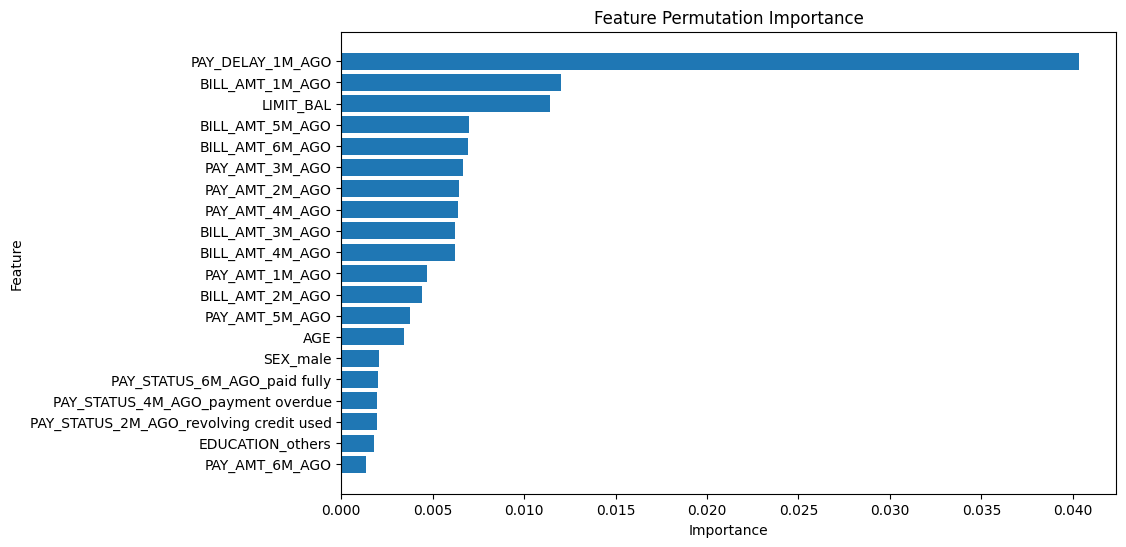

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_5M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_6M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:

In [ ]:
xgb2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   835  3698  975   492      46.13   62.92        79.14     75.55     53.24   
1   736  3778  895   591      45.13   55.46        80.85     75.23     49.76   
2   571  4126  547   756      51.07   43.03        88.29     78.28     46.71   
3   541  4203  470   786      53.51   40.77        89.94     79.07     46.28   
4   531  4223  450   796      54.13   40.02        90.37     79.23     46.01   
5   542  4212  461   785      54.04   40.84        90.13     79.23     46.52   
6   538  4224  449   789      54.51   40.54        90.39     79.37     46.50   
7   527  4239  434   800      54.84   39.71        90.71     79.43     46.07   
8   507  4246  427   820      54.28   38.21        90.86     79.22     44.85   
9   511  4249  424   816      54.65   38.51        90.93     79.33     45.18   
10  527  4231  442   800      54.39   39.71        90.54     79.30     45.91   
11  463  4293  380   864      54.92   34.89        91.87     79.27     42.67   
12  459  4294  379   868      54.77   34.59        91.89     79.22     42.40   
13  437  4324  349   890      55.60   32.93        92.53     79.35     41.36   
14  439  4322  351   888      55.57   33.08        92.49     79.35     41.47   
15  429  4332  341   898      55.71   32.33        92.70     79.35     40.92   
16  402  4368  305   925      56.86   30.29        93.47     79.50     39.53   
17  356  4430  243   971      59.43   26.83        94.80     79.77     36.97   
18  282  4519  154  1045      64.68   21.25        96.70     80.02     31.99   
19  271  4528  145  1056      65.14   20.42        96.90     79.98     31.10   
20  333  4471  202   994      62.24   25.09        95.68     80.07     35.77   

    balanced_accuracy  num_feat_missing  \
0               71.03                 0   
1               68.16                 1   
2               65.66                 2   
3               65.36                 3   
4               65.19                 4   
5               65.49                 5   
6               65.47                 6   
7               65.21                 7   
8               64.53                 8   
9               64.72                 9   
10              65.13                10   
11              63.38                11   
12              63.24                12   
13              62.73                13   
14              62.79                14   
15              62.52                15   
16              61.88                16   
17              60.81                17   
18              58.98                18   
19              58.66                19   
20              60.39                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:57:57.043102

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
xgb2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   835  3698  975  492      46.13   62.92        79.14     75.55     53.24   
1   752  3763  910  575      45.25   56.67        80.53     75.25     50.32   
2   717  3877  796  610      47.39   54.03        82.97     76.57     50.49   
3   661  3978  695  666      48.75   49.81        85.13     77.32     49.27   
4   622  4076  597  705      51.03   46.87        87.22     78.30     48.86   
5   600  4122  551  727      52.13   45.21        88.21     78.70     48.43   
6   599  4133  540  728      52.59   45.14        88.44     78.87     48.58   
7   578  4162  511  749      53.08   43.56        89.06     79.00     47.85   
8   557  4194  479  770      53.76   41.97        89.75     79.18     47.14   
9   577  4179  494  750      53.87   43.48        89.43     79.27     48.12   
10  579  4190  483  748      54.52   43.63        89.66     79.48     48.47   
11  563  4186  487  764      53.62   42.43        89.58     79.15     47.37   
12  583  4129  544  744      51.73   43.93        88.36     78.53     47.51   
13  598  4112  561  729      51.60   45.06        87.99     78.50     48.11   
14  589  4133  540  738      52.17   44.39        88.44     78.70     47.96   
15  579  4142  531  748      52.16   43.63        88.64     78.68     47.52   
16  565  4161  512  762      52.46   42.58        89.04     78.77     47.00   
17  523  4236  437  804      54.48   39.41        90.65     79.32     45.74   
18  520  4247  426  807      54.97   39.19        90.88     79.45     45.75   
19  534  4240  433  793      55.22   40.24        90.73     79.57     46.56   
20  530  4236  437  797      54.81   39.94        90.65     79.43     46.21   

    balanced_accuracy  num_feat_missing  \
0               71.03                 0   
1               68.60                 1   
2               68.50                 2   
3               67.47                 3   
4               67.05                 4   
5               66.71                 5   
6               66.79                 6   
7               66.31                 7   
8               65.86                 8   
9               66.46                 9   
10              66.65                10   
11              66.00                11   
12              66.15                12   
13              66.53                13   
14              66.42                14   
15              66.13                15   
16              65.81                16   
17              65.03                17   
18              65.03                18   
19              65.49                19   
20              65.29                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
xgb2_perf_temp, xgb2_orig_missing_temp, xgb2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
xgb2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  835  3698  975   492      46.13   62.92        79.14     75.55     53.24   
1  460  4274  399   867      53.55   34.66        91.46     78.90     42.09   
2  427  4301  372   900      53.44   32.18        92.04     78.80     40.17   
3  372  4371  302   955      55.19   28.03        93.54     79.05     37.18   
4  395  4364  309   932      56.11   29.77        93.39     79.32     38.90   
5  239  4532  141  1088      62.89   18.01        96.98     79.52     28.00   
6   17  4659   14  1310      54.84    1.28        99.70     77.93      2.50   

   balanced_accuracy  num_feat_missing  \
0              71.03                 0   
1              63.06                 4   
2              62.11                 5   
3              60.79                 9   
4              61.58                13   
5              57.50                17   
6              50.49                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_temp_mf, xgb2_orig_missing_temp_mf, xgb2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:04:37.214476

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
xgb2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  835  3698  975   492      46.13   62.92        79.14     75.55     53.24   
1  645  3884  789   682      44.98   48.61        83.12     75.48     46.72   
2  594  4033  640   733      48.14   44.76        86.30     77.12     46.39   
3  571  4075  598   756      48.85   43.03        87.20     77.43     45.75   
4  518  4226  447   809      53.68   39.04        90.43     79.07     45.20   
5  481  4275  398   846      54.72   36.25        91.48     79.27     43.61   
6  170  4555  118  1157      59.03   12.81        97.47     78.75     21.05   

   balanced_accuracy  num_feat_missing  \
0              71.03                 0   
1              65.86                 4   
2              65.53                 5   
3              65.12                 9   
4              64.73                13   
5              63.87                17   
6              55.14                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 17:06:37.241129

Nested Cross-validation Results:
Individual scores: [0.71806788 0.70376346 0.71192925]
Average nested CV score: 0.711 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.711
2025-01-18 17:06:46.619518

Execution time: 0.16 minutes


```
Starting hyperparameter tuning at: 2025-01-17 14:50:59.719030

Nested Cross-validation Results:
Individual scores: [0.71328082 0.70250474 0.71051364]
Average nested CV score: 0.709 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.711
2025-01-17 15:49:08.587893

Execution time: 58.15 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.021926  0.000507
44  PAY_STATUS_6M_AGO_revolving credit used    0.015149  0.000900
2                           BILL_AMT_1M_AGO    0.014743  0.000951
3                           BILL_AMT_2M_AGO    0.013964  0.001196
0                                 LIMIT_BAL    0.013932  0.001249
28        PAY_STATUS_1M_AGO_payment overdue    0.012996  0.000405
7                           BILL_AMT_6M_AGO    0.012475  0.001370
5                           BILL_AMT_4M_AGO    0.012054  0.000806
29  PAY_STATUS_1M_AGO_revolving credit used    0.011720  0.001171
4                           BILL_AMT_3M_AGO    0.011565  0.000862
35  PAY_STATUS_3M_AGO_revolving credit used    0.011525  0.000068
6                           BILL_AMT_5M_AGO    0.011311  0.000716
32  PAY_STATUS_2M_AGO_revolving credit used    0.011088  0.000678
11                           PAY_AMT_4M_AGO    0.009350  0.000714
10                           PAY_AMT_3M_AGO    0.009056  0.001074
23                     EDUCATION_university    0.008910  0.000950
33             PAY_STATUS_3M_AGO_paid fully    0.008869  0.000561
30             PAY_STATUS_2M_AGO_paid fully    0.008863  0.000403
20                                 SEX_male    0.008748  0.000937
41  PAY_STATUS_5M_AGO_revolving credit used    0.008367  0.000966
9                            PAY_AMT_2M_AGO    0.008179  0.000433
27             PAY_STATUS_1M_AGO_paid fully    0.007815  0.000562
8                            PAY_AMT_1M_AGO    0.007089  0.000533
38  PAY_STATUS_4M_AGO_revolving credit used    0.007067  0.000334
12                           PAY_AMT_5M_AGO    0.007048  0.001027
42             PAY_STATUS_6M_AGO_paid fully    0.007021  0.000259
39             PAY_STATUS_5M_AGO_paid fully    0.006326  0.000339
26                          MARRIAGE_single    0.006191  0.000456
24                         MARRIAGE_married    0.005282  0.000621
36             PAY_STATUS_4M_AGO_paid fully    0.004961  0.000624
1                                       AGE    0.004681  0.000295
13                           PAY_AMT_6M_AGO    0.004417  0.000555
34        PAY_STATUS_3M_AGO_payment overdue    0.003233  0.000790
21                    EDUCATION_high school    0.003053  0.000346
43        PAY_STATUS_6M_AGO_payment overdue    0.002361  0.000689
40        PAY_STATUS_5M_AGO_payment overdue    0.002162  0.000447
22                         EDUCATION_others    0.002085  0.000645
37        PAY_STATUS_4M_AGO_payment overdue    0.001909  0.000985
18                         PAY_DELAY_5M_AGO    0.001573  0.000311
19                         PAY_DELAY_6M_AGO    0.001454  0.000267
16                         PAY_DELAY_3M_AGO    0.001395  0.000824
17                         PAY_DELAY_4M_AGO    0.001166  0.000925
31        PAY_STATUS_2M_AGO_payment overdue    0.000565  0.000896
25                          MARRIAGE_others    0.000475  0.000039
15                         PAY_DELAY_2M_AGO   -0.004247  0.001536

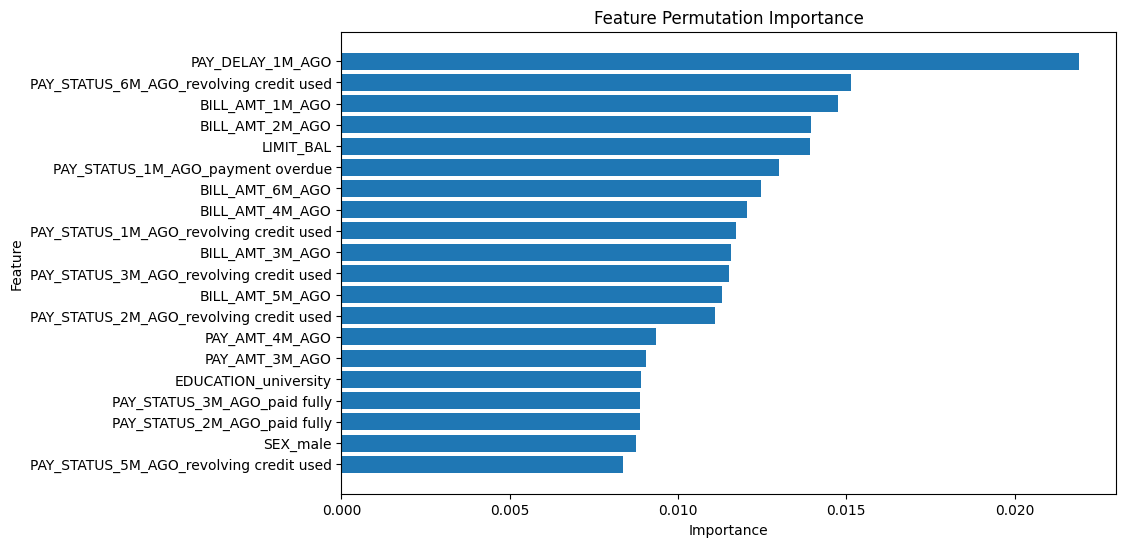

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_payment overdue', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related featu

In [ ]:
et2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   782  3866  807   545      49.21   58.93        82.73     77.47     53.64   
1   696  3935  738   631      48.54   52.45        84.21     77.18     50.42   
2   602  4101  572   725      51.28   45.37        87.76     78.38     48.14   
3   592  4112  561   735      51.34   44.61        87.99     78.40     47.74   
4   593  4112  561   734      51.39   44.69        87.99     78.42     47.80   
5   585  4135  538   742      52.09   44.08        88.49     78.67     47.76   
6   592  4097  576   735      50.68   44.61        87.67     78.15     47.45   
7   590  4104  569   737      50.91   44.46        87.82     78.23     47.47   
8   588  4099  574   739      50.60   44.31        87.72     78.12     47.25   
9   588  4095  578   739      50.43   44.31        87.63     78.05     47.17   
10  579  4111  562   748      50.74   43.63        87.97     78.17     46.92   
11  579  4110  563   748      50.70   43.63        87.95     78.15     46.90   
12  424  4293  380   903      52.74   31.95        91.87     78.62     39.79   
13  425  4291  382   902      52.66   32.03        91.83     78.60     39.83   
14  428  4291  382   899      52.84   32.25        91.83     78.65     40.06   
15  426  4301  372   901      53.38   32.10        92.04     78.78     40.09   
16  427  4297  376   900      53.18   32.18        91.95     78.73     40.09   
17  396  4323  350   931      53.08   29.84        92.51     78.65     38.21   
18  396  4321  352   931      52.94   29.84        92.47     78.62     38.17   
19  392  4322  351   935      52.76   29.54        92.49     78.57     37.87   
20  304  4479  194  1023      61.04   22.91        95.85     79.72     33.32   

    balanced_accuracy  num_feat_missing  \
0               70.83                 0   
1               68.33                 1   
2               66.56                 2   
3               66.30                 3   
4               66.34                 4   
5               66.29                 5   
6               66.14                 6   
7               66.14                 7   
8               66.01                 8   
9               65.97                 9   
10              65.80                10   
11              65.79                11   
12              61.91                12   
13              61.93                13   
14              62.04                14   
15              62.07                15   
16              62.07                16   
17              61.18                17   
18              61.15                18   
19              61.01                19   
20              59.38                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:07:01.373913

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
et2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   782  3866  807  545      49.21   58.93        82.73     77.47     53.64   
1   707  3905  768  620      47.93   53.28        83.57     76.87     50.46   
2   672  3968  705  655      48.80   50.64        84.91     77.33     49.70   
3   651  4015  658  676      49.73   49.06        85.92     77.77     49.39   
4   628  4061  612  699      50.65   47.32        86.90     78.15     48.93   
5   616  4069  604  711      50.49   46.42        87.07     78.08     48.37   
6   602  4058  615  725      49.47   45.37        86.84     77.67     47.33   
7   604  4055  618  723      49.43   45.52        86.78     77.65     47.39   
8   604  4053  620  723      49.35   45.52        86.73     77.62     47.35   
9   605  4057  616  722      49.55   45.59        86.82     77.70     47.49   
10  585  4095  578  742      50.30   44.08        87.63     78.00     46.99   
11  584  4095  578  743      50.26   44.01        87.63     77.98     46.93   
12  529  4169  504  798      51.21   39.86        89.21     78.30     44.83   
13  537  4177  496  790      51.98   40.47        89.39     78.57     45.51   
14  534  4176  497  793      51.79   40.24        89.36     78.50     45.29   
15  534  4173  500  793      51.64   40.24        89.30     78.45     45.24   
16  533  4181  492  794      52.00   40.17        89.47     78.57     45.32   
17  505  4208  465  822      52.06   38.06        90.05     78.55     43.97   
18  508  4201  472  819      51.84   38.28        89.90     78.48     44.04   
19  511  4197  476  816      51.77   38.51        89.81     78.47     44.17   
20  478  4279  394  849      54.82   36.02        91.57     79.28     43.47   

    balanced_accuracy  num_feat_missing  \
0               70.83                 0   
1               68.42                 1   
2               67.78                 2   
3               67.49                 3   
4               67.11                 4   
5               66.75                 5   
6               66.10                 6   
7               66.15                 7   
8               66.12                 8   
9               66.20                 9   
10              65.86                10   
11              65.82                11   
12              64.54                12   
13              64.93                13   
14              64.80                14   
15              64.77                15   
16              64.82                16   
17              64.05                17   
18              64.09                18   
19              64.16                19   
20              63.79                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...

In [ ]:
et2_perf_temp, et2_orig_missing_temp, et2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
et2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  782  3866  807   545      49.21   58.93        82.73     77.47     53.64   
1  632  4034  639   695      49.72   47.63        86.33     77.77     48.65   
2  593  4081  592   734      50.04   44.69        87.33     77.90     47.21   
3  430  4261  412   897      51.07   32.40        91.18     78.18     39.65   
4  396  4292  381   931      50.97   29.84        91.85     78.13     37.64   
5  274  4486  187  1053      59.44   20.65        96.00     79.33     30.65   
6   17  4662   11  1310      60.71    1.28        99.76     77.98      2.51   

   balanced_accuracy  num_feat_missing  \
0              70.83                 0   
1              66.98                 4   
2              66.01                 8   
3              61.79                12   
4              60.84                13   
5              58.32                17   
6              50.52                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_temp_mf, et2_orig_missing_temp_mf, et2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:13:49.794902

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
et2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  782  3866  807   545      49.21   58.93        82.73     77.47     53.64   
1  668  3935  738   659      47.51   50.34        84.21     76.72     48.88   
2  612  4049  624   715      49.51   46.12        86.65     77.68     47.76   
3  476  4163  510   851      48.28   35.87        89.09     77.32     41.16   
4  478  4166  507   849      48.53   36.02        89.15     77.40     41.35   
5  452  4226  447   875      50.28   34.06        90.43     77.97     40.61   
6  165  4566  107  1162      60.66   12.43        97.71     78.85     20.64   

   balanced_accuracy  num_feat_missing  \
0              70.83                 0   
1              67.27                 4   
2              66.38                 8   
3              62.48                12   
4              62.59                13   
5              62.25                17   
6              55.07                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1],
  }
else:
  # best model
  svm2_param_grid = {
      'C': [0.1],
      'kernel': ['rbf'],
      'gamma': ['scale']
}

svm2_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy',
    X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 17:15:51.876741

Nested Cross-validation Results:
Individual scores: [0.70893114 0.70012016 0.70608728]
Average nested CV score: 0.705 (+/- 0.007)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.705
2025-01-18 17:17:20.431060

Execution time: 1.48 minutes


```
Starting hyperparameter tuning at: 2025-01-17 13:21:50.337641

Nested Cross-validation Results:
Individual scores: [0.70871907 0.69351325 0.7029958 ]
Average nested CV score: 0.702 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.705
2025-01-17 13:46:46.581678

Execution time: 24.94 minutes
```

In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(
    svm2_classifier, X_train_scaled, y_train,
    scoring_metric="balanced_accuracy", n_repeats=3
)
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue    0.081320  0.001843
31        PAY_STATUS_2M_AGO_payment overdue    0.005431  0.000975
34        PAY_STATUS_3M_AGO_payment overdue    0.003746  0.000106
37        PAY_STATUS_4M_AGO_payment overdue    0.001841  0.000188
27             PAY_STATUS_1M_AGO_paid fully    0.001553  0.000199
16                         PAY_DELAY_3M_AGO    0.001150  0.000100
44  PAY_STATUS_6M_AGO_revolving credit used    0.000916  0.000455
40        PAY_STATUS_5M_AGO_payment overdue    0.000861  0.000259
36             PAY_STATUS_4M_AGO_paid fully    0.000807  0.000569
43        PAY_STATUS_6M_AGO_payment overdue    0.000633  0.000114
0                                 LIMIT_BAL    0.000631  0.000176
35  PAY_STATUS_3M_AGO_revolving credit used    0.000581  0.000192
21                    EDUCATION_high school    0.000528  0.000023
20                                 SEX_male    0.000496  0.000325
24                         MARRIAGE_married    0.000480  0.000139
26                          MARRIAGE_single    0.000435  0.000247
33             PAY_STATUS_3M_AGO_paid fully    0.000423  0.000272
32  PAY_STATUS_2M_AGO_revolving credit used    0.000402  0.000362
39             PAY_STATUS_5M_AGO_paid fully    0.000381  0.000072
23                     EDUCATION_university    0.000349  0.000256
41  PAY_STATUS_5M_AGO_revolving credit used    0.000290  0.000549
19                         PAY_DELAY_6M_AGO    0.000202  0.000126
6                           BILL_AMT_5M_AGO    0.000126  0.000049
8                            PAY_AMT_1M_AGO    0.000067  0.000050
42             PAY_STATUS_6M_AGO_paid fully    0.000065  0.000175
18                         PAY_DELAY_5M_AGO    0.000058  0.000094
1                                       AGE    0.000049  0.000117
13                           PAY_AMT_6M_AGO    0.000040  0.000040
5                           BILL_AMT_4M_AGO    0.000031  0.000044
10                           PAY_AMT_3M_AGO    0.000027  0.000000
22                         EDUCATION_others    0.000022  0.000054
9                            PAY_AMT_2M_AGO    0.000009  0.000013
25                          MARRIAGE_others   -0.000018  0.000013
3                           BILL_AMT_2M_AGO   -0.000045  0.000052
15                         PAY_DELAY_2M_AGO   -0.000074  0.000088
17                         PAY_DELAY_4M_AGO   -0.000122  0.000097
38  PAY_STATUS_4M_AGO_revolving credit used   -0.000151  0.000110
14                         PAY_DELAY_1M_AGO   -0.000332  0.000252
30             PAY_STATUS_2M_AGO_paid fully   -0.000519  0.000437
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000537  0.000441

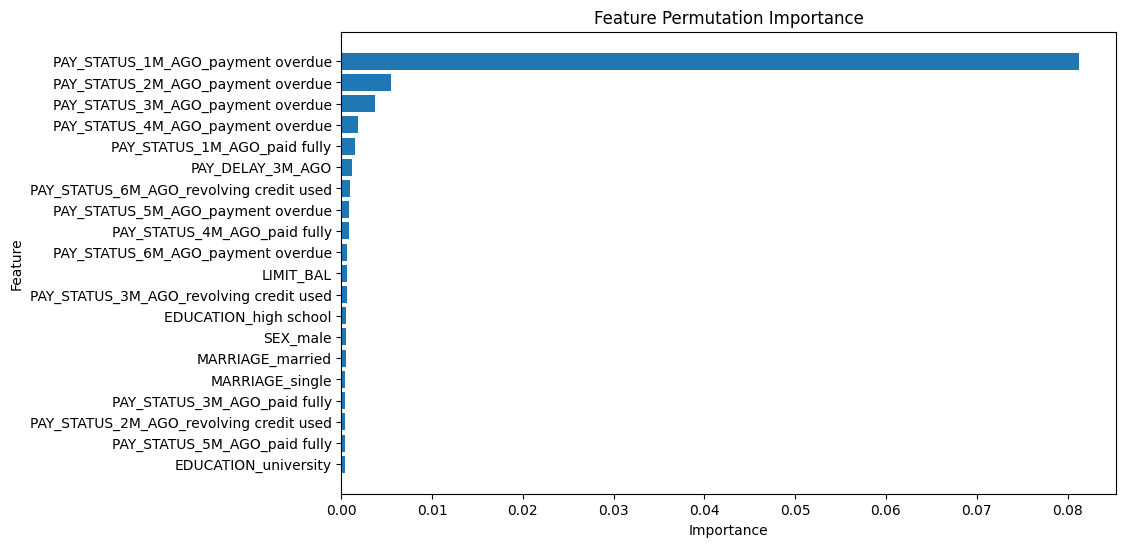

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_4M_AGO_pai

In [ ]:
svm2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   737  3913  760   590      49.23   55.54        83.74     77.50     52.20   
1   502  4212  461   825      52.13   37.83        90.13     78.57     43.84   
2   426  4303  370   901      53.52   32.10        92.08     78.82     40.13   
3   305  4468  205  1022      59.80   22.98        95.61     79.55     33.21   
4   143  4597   76  1184      65.30   10.78        98.37     79.00     18.50   
5   126  4603   70  1201      64.29    9.50        98.50     78.82     16.55   
6    15  4667    6  1312      71.43    1.13        99.87     78.03      2.23   
7     1  4672    1  1326      50.00    0.08        99.98     77.88      0.15   
8     1  4672    1  1326      50.00    0.08        99.98     77.88      0.15   
9     1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
10    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
11    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
12    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
13    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
14    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.64                 0   
1               63.98                 1   
2               62.09                 2   
3               59.30                 3   
4               54.57                 4   
5               54.00                 5   
6               50.50                 6   
7               50.03                 7   
8               50.03                 8   
9               50.04                 9   
10              50.04                10   
11              50.04                11   
12              50.04                12   
13              50.04                13   
14              50.04                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:30:09.008720

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
svm2_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   737  3913   760   590      49.23   55.54        83.74     77.50     52.20   
1   590  4029   644   737      47.81   44.46        86.22     76.98     46.08   
2   598  3651  1022   729      36.91   45.06        78.13     70.82     40.58   
3   289  4485   188  1038      60.59   21.78        95.98     79.57     32.04   
4   126  4601    72  1201      63.64    9.50        98.46     78.78     16.52   
5   126  4601    72  1201      63.64    9.50        98.46     78.78     16.52   
6     8  4668     5  1319      61.54    0.60        99.89     77.93      1.19   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.64                 0   
1               65.34                 1   
2               61.60                 2   
3               58.88                 3   
4               53.98                 4   
5               53.98                 5   
6               50.25                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm2_perf_temp, svm2_orig_missing_temp, svm2_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
svm2_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   737  3913   760  590      49.23   55.54        83.74     77.50     52.20   
1  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
2  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
3  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
4  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
5  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              69.64                 0   
1              50.00                 4   
2              50.00                 8   
3              50.00                12   
4              50.00                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_temp_mf, svm2_orig_missing_temp_mf, svm2_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:39:34.918021

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
svm2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  737  3913   760   590      49.23   55.54        83.74     77.50     52.20   
1  590  4027   646   737      47.73   44.46        86.18     76.95     46.04   
2  595  3655  1018   732      36.89   44.84        78.22     70.83     40.48   
3  286  4486   187  1041      60.47   21.55        96.00     79.53     31.78   
4   79  4626    47  1248      62.70    5.95        98.99     78.42     10.87   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.64                 0   
1              65.32                 4   
2              61.53                 8   
3              58.78                12   
4              52.47                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [2.0],
      'penalty': ['l2'],
      'solver': ['saga']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 17:41:45.950087

Nested Cross-validation Results:
Individual scores: [0.70686988 0.70768924 0.70425724]
Average nested CV score: 0.706 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-18 17:41:51.388434

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-17 13:46:46.598291

Nested Cross-validation Results:
Individual scores: [0.70651774 0.70704718 0.70381741]
Average nested CV score: 0.706 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-17 13:47:12.983596

Execution time: 0.44 minutes
```

In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.077434  0.002468
7                                 LIMIT_BAL    0.012833  0.002226
2                          PAY_DELAY_3M_AGO    0.007913  0.001685
23             PAY_STATUS_1M_AGO_paid fully    0.005131  0.001013
6   PAY_STATUS_1M_AGO_revolving credit used    0.004194  0.000845
17  PAY_STATUS_6M_AGO_revolving credit used    0.003793  0.001100
4                          PAY_DELAY_5M_AGO    0.003292  0.000586
19             PAY_STATUS_2M_AGO_paid fully    0.003250  0.000593
30                          BILL_AMT_1M_AGO    0.002442  0.000289
3                          PAY_DELAY_4M_AGO    0.002375  0.000397
25                                 SEX_male    0.002166  0.000279
16  PAY_STATUS_5M_AGO_revolving credit used    0.001362  0.000506
20             PAY_STATUS_4M_AGO_paid fully    0.001212  0.000344
24                         EDUCATION_others    0.001107  0.000334
27                          MARRIAGE_single    0.000768  0.000923
26                     EDUCATION_university    0.000751  0.000212
8                            PAY_AMT_1M_AGO    0.000633  0.000265
5                          PAY_DELAY_6M_AGO    0.000470  0.000089
10  PAY_STATUS_3M_AGO_revolving credit used    0.000457  0.000797
14  PAY_STATUS_4M_AGO_revolving credit used    0.000450  0.000604
32                          MARRIAGE_others    0.000387  0.000176
29                                      AGE    0.000274  0.000458
15                           PAY_AMT_6M_AGO    0.000250  0.000274
22             PAY_STATUS_6M_AGO_paid fully    0.000138  0.000405
13                           PAY_AMT_5M_AGO    0.000114  0.000318
28                    EDUCATION_high school    0.000100  0.000138
11                           PAY_AMT_3M_AGO    0.000043  0.000418
9                            PAY_AMT_2M_AGO    0.000031  0.000127
12                           PAY_AMT_4M_AGO    0.000006  0.000335
1                          PAY_DELAY_2M_AGO   -0.000135  0.000326
18             PAY_STATUS_3M_AGO_paid fully   -0.000149  0.000120
21             PAY_STATUS_5M_AGO_paid fully   -0.000253  0.000127
31                          BILL_AMT_6M_AGO   -0.000275  0.000291

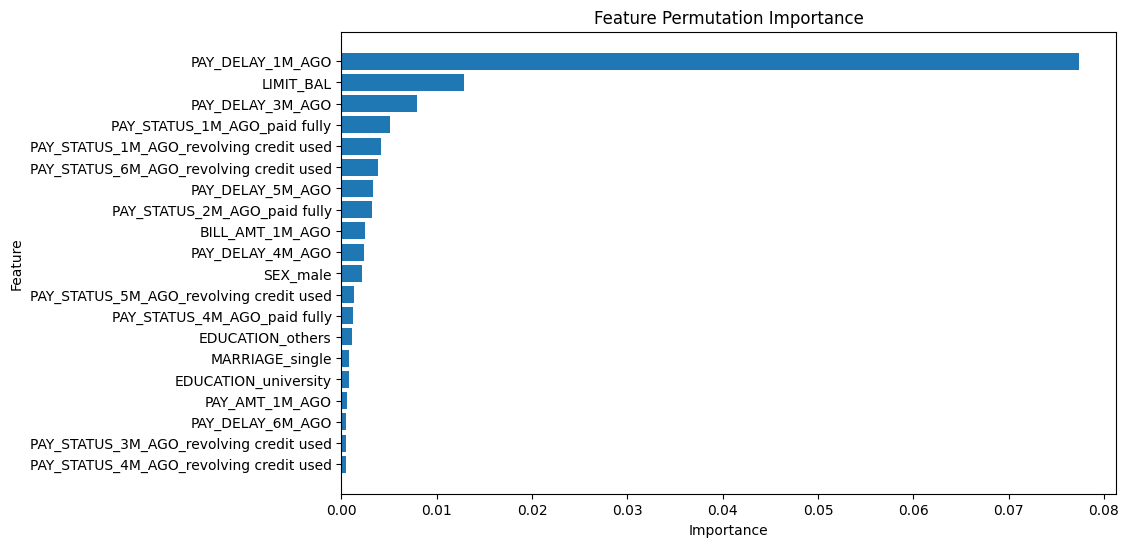

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW IT

In [ ]:
lr2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1   485  4169  504   842      49.04   36.55        89.21     77.57     41.88   
2   442  4214  459   885      49.06   33.31        90.18     77.60     39.68   
3   334  4351  322   993      50.91   25.17        93.11     78.08     33.69   
4   364  4195  478   963      43.23   27.43        89.77     75.98     33.56   
5   184  4427  246  1143      42.79   13.87        94.74     76.85     20.94   
6    63  4507  166  1264      27.51    4.75        96.45     76.17      8.10   
7    63  4507  166  1264      27.51    4.75        96.45     76.17      8.10   
8    16  4660   13  1311      55.17    1.21        99.72     77.93      2.36   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               62.88                 1   
2               61.74                 2   
3               59.14                 3   
4               58.60                 4   
5               54.30                 5   
6               50.60                 6   
7               50.60                 7   
8               50.46                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)


print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:41:53.873510

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811  577      48.05   56.52        82.64     76.87     51.94   
1   699  3804  869  628      44.58   52.68        81.40     75.05     48.29   
2   676  3884  789  651      46.14   50.94        83.12     76.00     48.42   
3   663  3892  781  664      45.91   49.96        83.29     75.92     47.85   
4   633  3927  746  694      45.90   47.70        84.04     76.00     46.78   
5   628  3988  685  699      47.83   47.32        85.34     76.93     47.58   
6   610  4007  666  717      47.81   45.97        85.75     76.95     46.87   
7   608  4014  659  719      47.99   45.82        85.90     77.03     46.88   
8   583  4081  592  744      49.62   43.93        87.33     77.73     46.60   
9   547  4112  561  780      49.37   41.22        87.99     77.65     44.93   
10  514  4196  477  813      51.87   38.73        89.79     78.50     44.35   
11  472  4292  381  855      55.33   35.57        91.85     79.40     43.30   
12  456  4311  362  871      55.75   34.36        92.25     79.45     42.52   
13  460  4304  369  867      55.49   34.66        92.10     79.40     42.67   
14  448  4322  351  879      56.07   33.76        92.49     79.50     42.14   
15  465  4294  379  862      55.09   35.04        91.89     79.32     42.84   
16  464  4301  372  863      55.50   34.97        92.04     79.42     42.90   
17  466  4300  373  861      55.54   35.12        92.02     79.43     43.03   
18  466  4299  374  861      55.48   35.12        92.00     79.42     43.01   
19  468  4299  374  859      55.58   35.27        92.00     79.45     43.15   
20  469  4296  377  858      55.44   35.34        91.93     79.42     43.17   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               67.04                 1   
2               67.03                 2   
3               66.62                 3   
4               65.87                 4   
5               66.33                 5   
6               65.86                 6   
7               65.86                 7   
8               65.63                 8   
9               64.61                 9   
10              64.26                10   
11              63.71                11   
12              63.31                12   
13              63.38                13   
14              63.12                14   
15              63.47                15   
16              63.50                16   
17              63.57                17   
18              63.56                18   
19              63.63                19   
20              63.64                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr2_perf_temp, lr2_orig_missing_temp, lr2_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862   811   577      48.05   56.52        82.64     76.87     51.94   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                12   
5              50.00                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_temp_mf, lr2_orig_missing_temp_mf, lr2_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:46:37.344699

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1  619  3925  748   708      45.28   46.65        83.99     75.73     45.95   
2  639  3891  782   688      44.97   48.15        83.27     75.50     46.51   
3  576  4105  568   751      50.35   43.41        87.85     78.02     46.62   
4  606  4007  666   721      47.64   45.67        85.75     76.88     46.63   
5  554  4147  526   773      51.30   41.75        88.74     78.35     46.03   
6  170  4544  129  1157      56.86   12.81        97.24     78.57     20.91   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              65.32                 4   
2              65.71                 5   
3              65.63                 8   
4              65.71                12   
5              65.25                15   
6              55.03                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Results comparison - Standard Scenario**



## **F1-score**

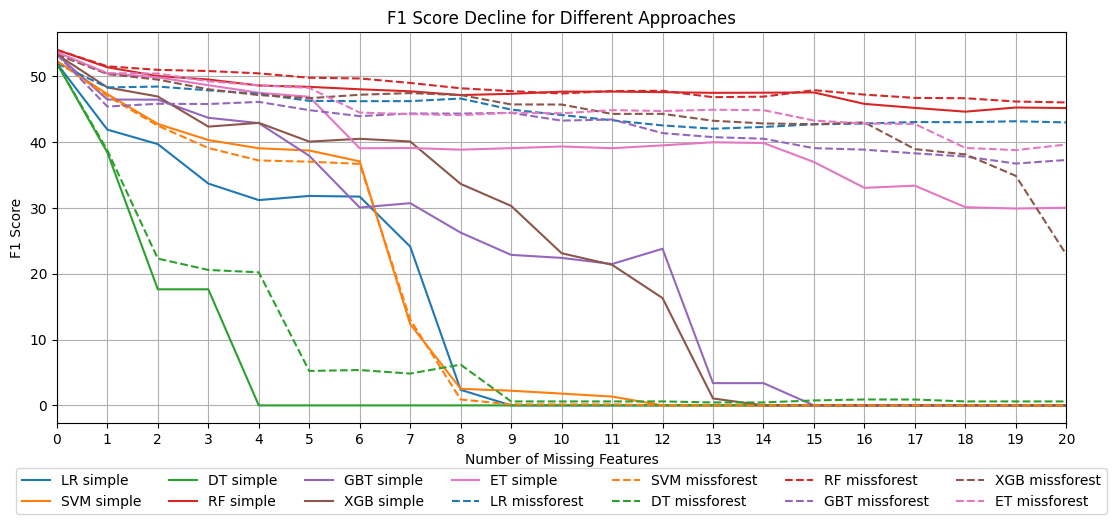

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

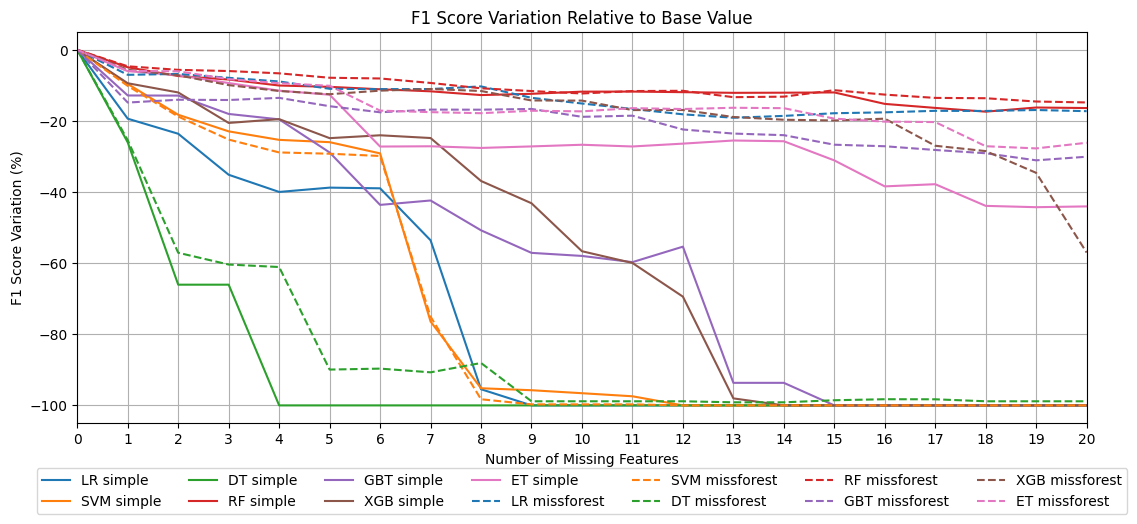

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

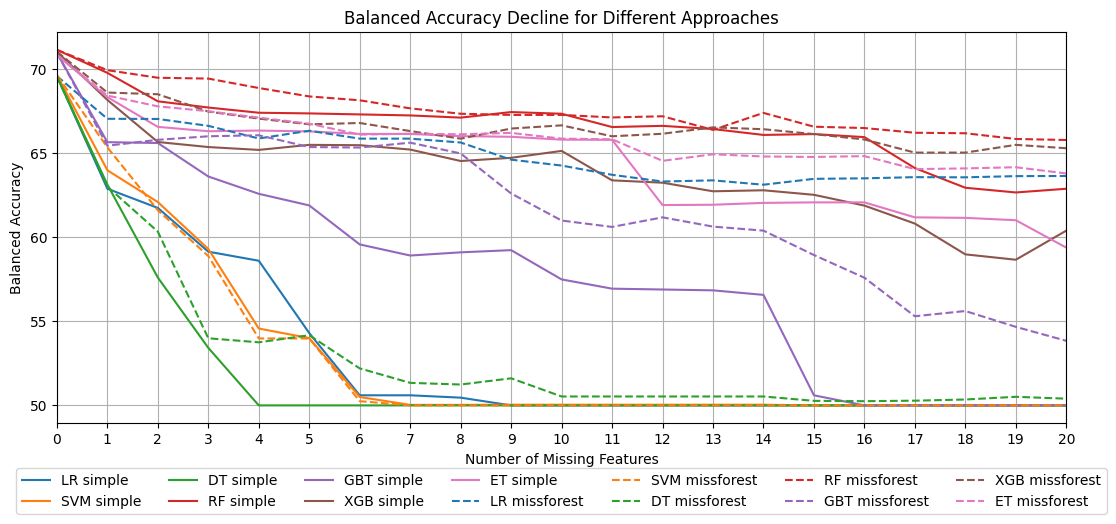

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

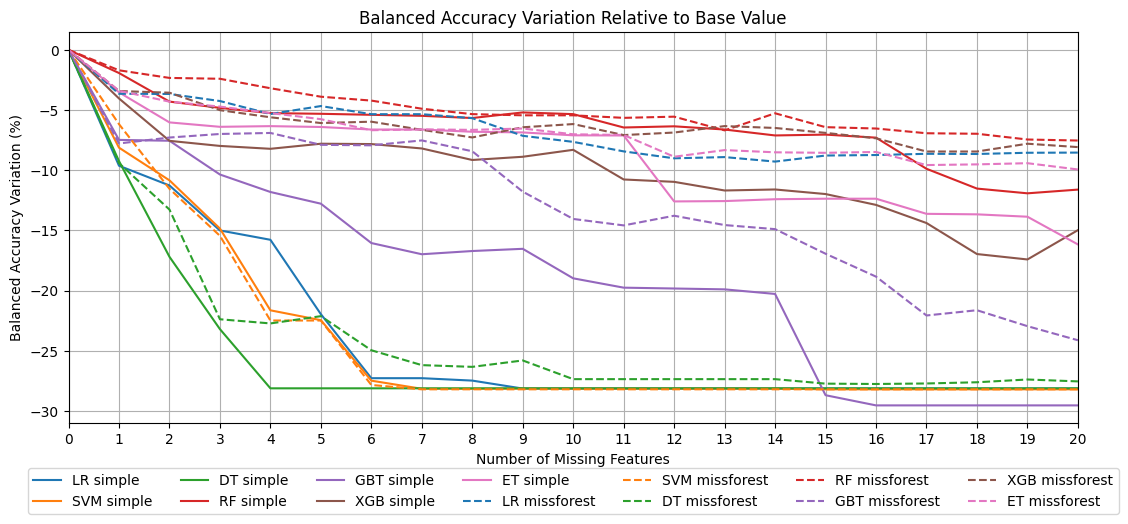

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Results comparison - Temporal Scenario**

## **F1-score**

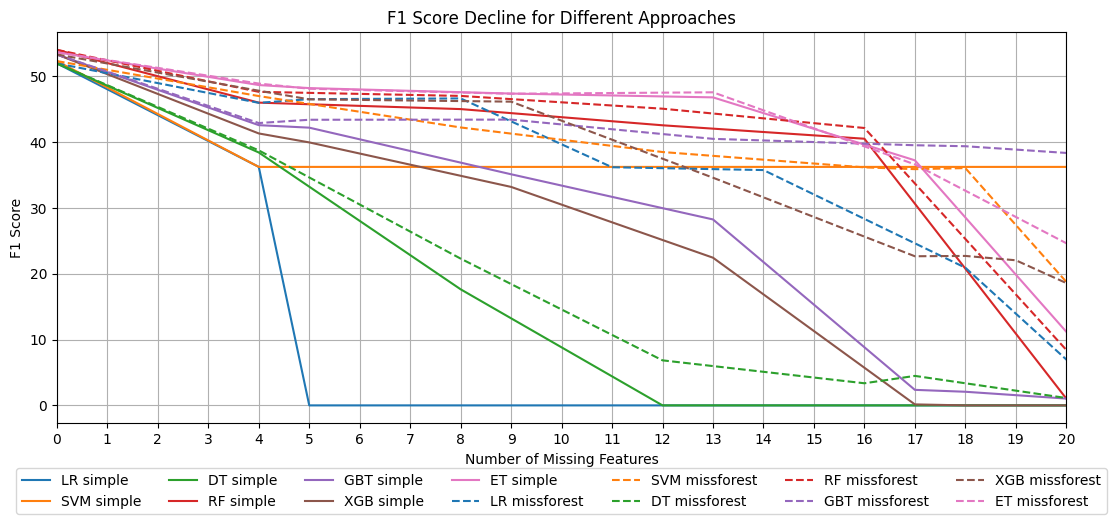

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf_temp['num_feat_missing'], lr_perf_temp['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf_temp['num_feat_missing'], svm_perf_temp['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf_temp['num_feat_missing'], dt_perf_temp['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf_temp['num_feat_missing'], rf_perf_temp['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf_temp['num_feat_missing'], gbt_perf_temp['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf_temp['num_feat_missing'], xgb_perf_temp['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf_temp['num_feat_missing'], et_perf_temp['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_temp_mf['num_feat_missing'], lr_perf_temp_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_temp_mf['num_feat_missing'], svm_perf_temp_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_temp_mf['num_feat_missing'], dt_perf_temp_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_temp_mf['num_feat_missing'], rf_perf_temp_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_temp_mf['num_feat_missing'], gbt_perf_temp_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_temp_mf['num_feat_missing'], xgb_perf_temp_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_temp_mf['num_feat_missing'], et_perf_temp_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

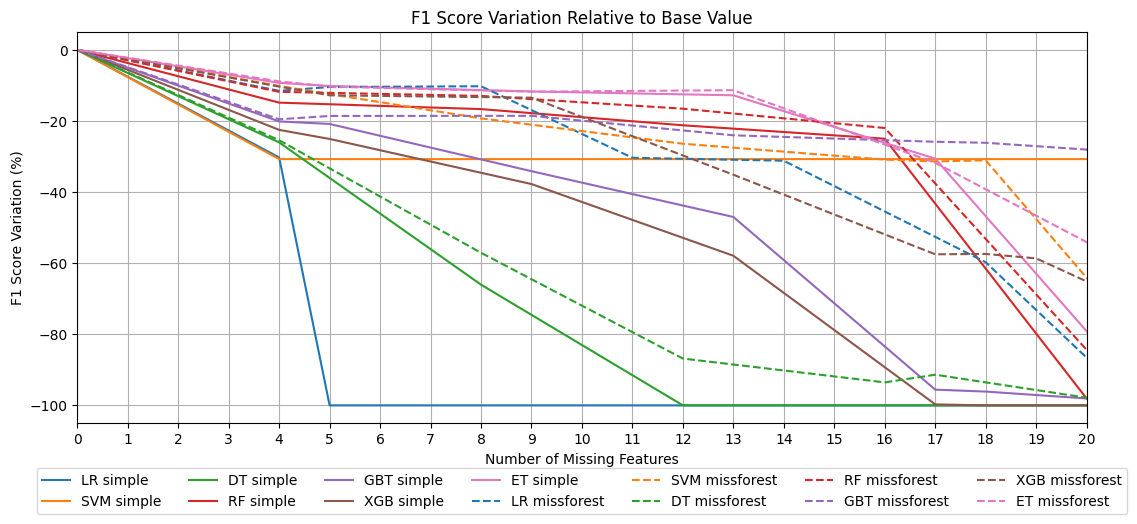

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf_temp, svm_perf_temp, dt_perf_temp, rf_perf_temp, gbt_perf_temp, xgb_perf_temp, et_perf_temp,
     lr_perf_temp_mf, svm_perf_temp_mf, dt_perf_temp_mf, rf_perf_temp_mf, gbt_perf_temp_mf, xgb_perf_temp_mf, et_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the first F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Balanced accuracy**

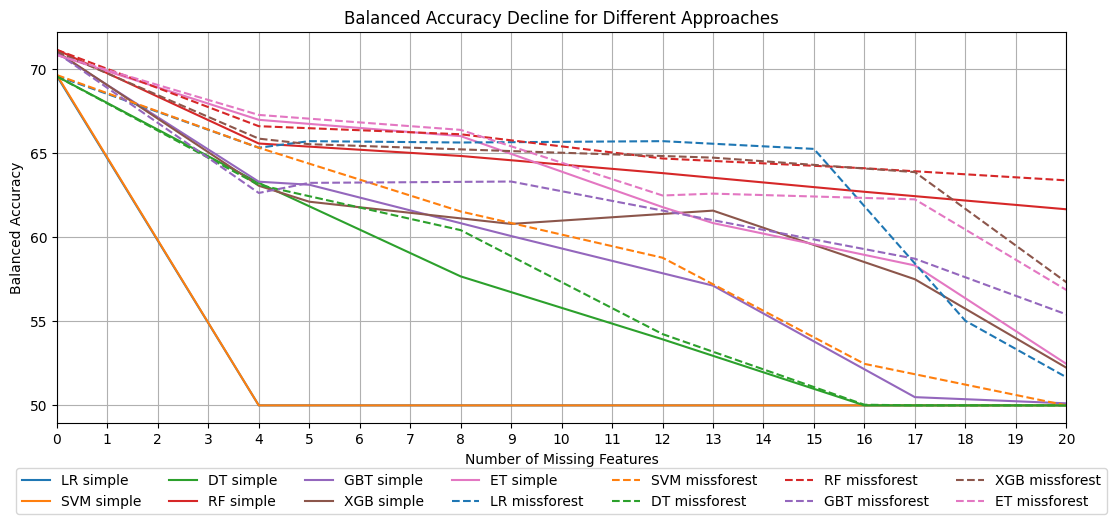

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf_temp['num_feat_missing'], lr2_perf_temp['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf_temp['num_feat_missing'], svm2_perf_temp['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf_temp['num_feat_missing'], dt2_perf_temp['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf_temp['num_feat_missing'], rf2_perf_temp['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf_temp['num_feat_missing'], gbt2_perf_temp['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf_temp['num_feat_missing'], xgb2_perf_temp['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf_temp['num_feat_missing'], et2_perf_temp['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_temp_mf['num_feat_missing'], lr2_perf_temp_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_temp_mf['num_feat_missing'], svm2_perf_temp_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_temp_mf['num_feat_missing'], dt2_perf_temp_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_temp_mf['num_feat_missing'], rf2_perf_temp_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_temp_mf['num_feat_missing'], gbt2_perf_temp_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_temp_mf['num_feat_missing'], xgb2_perf_temp_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_temp_mf['num_feat_missing'], et2_perf_temp_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

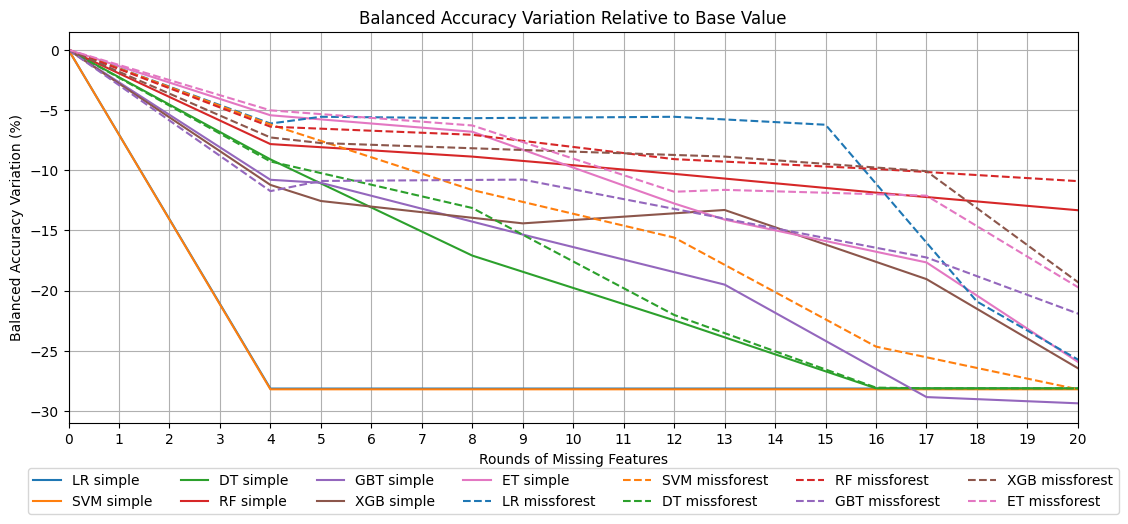

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the balanced accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf_temp, svm2_perf_temp, dt2_perf_temp, rf2_perf_temp, gbt2_perf_temp, xgb2_perf_temp, et2_perf_temp,
     lr2_perf_temp_mf, svm2_perf_temp_mf, dt2_perf_temp_mf, rf2_perf_temp_mf, gbt2_perf_temp_mf, xgb2_perf_temp_mf, et2_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base balanced accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Rounds of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf
}

all_data = combine_datasets(
    dataset_dict,
    'Default Credit Card',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data, 'default_cc_scenario1_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_temp_dict = {
    'lr_perf_temp': lr_perf_temp,
    'svm_perf_temp': svm_perf_temp,
    'dt_perf_temp': dt_perf_temp,
    'rf_perf_temp': rf_perf_temp,
    'gbt_perf_temp': gbt_perf_temp,
    'xgb_perf_temp': xgb_perf_temp,
    'et_perf_temp': et_perf_temp,
    'lr_perf_temp_mf': lr_perf_temp_mf,
    'svm_perf_temp_mf': svm_perf_temp_mf,
    'dt_perf_temp_mf': dt_perf_temp_mf,
    'rf_perf_temp_mf': rf_perf_temp_mf,
    'gbt_perf_temp_mf': gbt_perf_temp_mf,
    'xgb_perf_temp_mf': xgb_perf_temp_mf,
    'et_perf_temp_mf': et_perf_temp_mf,
    'lr2_perf_temp': lr2_perf_temp,
    'svm2_perf_temp': svm2_perf_temp,
    'dt2_perf_temp': dt2_perf_temp,
    'rf2_perf_temp': rf2_perf_temp,
    'gbt2_perf_temp': gbt2_perf_temp,
    'xgb2_perf_temp': xgb2_perf_temp,
    'et2_perf_temp': et2_perf_temp,
    'lr2_perf_temp_mf': lr2_perf_temp_mf,
    'svm2_perf_temp_mf': svm2_perf_temp_mf,
    'dt2_perf_temp_mf': dt2_perf_temp_mf,
    'rf2_perf_temp_mf': rf2_perf_temp_mf,
    'gbt2_perf_temp_mf': gbt2_perf_temp_mf,
    'xgb2_perf_temp_mf': xgb2_perf_temp_mf,
    'et2_perf_temp_mf': et2_perf_temp_mf
}

all_data_temp = combine_datasets(
    dataset_temp_dict,
    'Default Credit Card Temporal',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data_temp, 'default_cc_temp_scenario1_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0    750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1    485  4169  504   842      49.04   36.55        89.21     77.57     41.88   
2    442  4214  459   885      49.06   33.31        90.18     77.60     39.68   
3    334  4351  322   993      50.91   25.17        93.11     78.08     33.69   
4    302  4365  308  1025      49.51   22.76        93.41     77.78     31.18   
..   ...   ...  ...   ...        ...     ...          ...       ...       ...   
583  533  4181  492   794      52.00   40.17        89.47     78.57     45.32   
584  505  4208  465   822      52.06   38.06        90.05     78.55     43.97   
585  508  4201  472   819      51.84   38.28        89.90     78.48     44.04   
586  511  4197  476   816      51.77   38.51        89.81     78.47     44.17   
587  478  4279  394   849      54.82   36.02        91.57     79.28     43.47   

     balanced_accuracy  num_feat_missing  \
0                69.58                 0   
1                62.88                 1   
2                61.74                 2   
3                59.14                 3   
4                58.08                 4   
..                 ...               ...   
583              64.82                16   
584              64.05                17   
585              64.09                18   
586              64.16                19   
587              63.79                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                         ['PAY_DELAY_1M_AGO'] imputed      lr_perf   
2            ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed      lr_perf   
3    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...      lr_perf   
4    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...      lr_perf   
..                                                 ...          ...   
583  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  et2_perf_mf   
584  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  et2_perf_mf   
585  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  et2_perf_mf   
586  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  et2_perf_mf   
587  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_6M_AGO_paid f...  et2_perf_mf   

                  source              scenario  random_state  \
0    Default Credit Card  Scenario 1: standard          2024   
1    Default Credit Card  Scenario 1: standard          2024   
2    Default Credit Card  Scenario 1: standard          2024   
3    Default Credit Card  Scenario 1: standard          2024   
4    Default Credit Card  Scenario 1: standard          2024   
..                   ...                   ...           ...   
583  Default Credit Card  Scenario 1: standard          2024   
584  Default Credit Card  Scenario 1: standard          2024   
585  Default Credit Card  Scenario 1: standard          2024   
586  Default Credit Card  Scenario 1: standard          2024   
587  Default Credit Card  Scenario 1: standard          2024   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]

In [ ]:
all_data_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  \
0     750  3862   811   577      48.05   56.52        82.64     76.87   
1    1327     0  4673     0      22.12  100.00         0.00     22.12   
2       0  4673     0  1327       0.00    0.00       100.00     77.88   
3       0  4673     0  1327       0.00    0.00       100.00     77.88   
4       0  4673     0  1327       0.00    0.00       100.00     77.88   
..    ...   ...   ...   ...        ...     ...          ...       ...   
199   612  4049   624   715      49.51   46.12        86.65     77.68   
200   476  4163   510   851      48.28   35.87        89.09     77.32   
201   478  4166   507   849      48.53   36.02        89.15     77.40   
202   452  4226   447   875      50.28   34.06        90.43     77.97   
203   165  4566   107  1162      60.66   12.43        97.71     78.85   

     f1_score  balanced_accuracy  num_feat_missing  \
0       51.94              69.58                 0   
1       36.22              50.00                 4   
2        0.00              50.00                 5   
3        0.00              50.00                 8   
4        0.00              50.00                11   
..        ...                ...               ...   
199     47.76              66.38                 8   
200     41.16              62.48                12   
201     41.35              62.59                13   
202     40.61              62.25                17   
203     20.64              55.07                21   

                                               imputed           dataset  \
0                                                           lr_perf_temp   
1    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
2    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
3    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
4    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
..                                                 ...               ...   
199  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
200  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
201  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
202  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
203  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   

                           source              scenario  random_state  \
0    Default Credit Card Temporal  Scenario 1: standard          2024   
1    Default Credit Card Temporal  Scenario 1: standard          2024   
2    Default Credit Card Temporal  Scenario 1: standard          2024   
3    Default Credit Card Temporal  Scenario 1: standard          2024   
4    Default Credit Card Temporal  Scenario 1: standard          2024   
..                            ...                   ...           ...   
199  Default Credit Card Temporal  Scenario 1: standard          2024   
200  Default Credit Card Temporal  Scenario 1: standard          2024   
201  Default Credit Card Temporal  Scenario 1: standard          2024   
202  Default Credit Card Temporal  Scenario 1: standard          2024   
203  Default Credit Card Temporal  Scenario 1: standard          2024   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
199  balanced accuracy  
200  balanced accuracy  
201  balanced accuracy  
202  balanced accuracy  
203  balanced accuracy  

[204 rows x 17 columns]